## Initial setup

In [323]:
import pandas as pd
import numpy as np

train_meta = pd.read_csv("./train/train_metadata.csv")
train_add_features = pd.read_csv("./train/features/additional_features.csv")
train_color_hist = pd.read_csv("./train/features/color_histogram.csv")
train_hog_pca = pd.read_csv("./train/features/hog_pca.csv")


test_meta = pd.read_csv("./test/test_metadata.csv")
# test_meta.drop("ClassId", inplace=True, axis=1) # useless for now
test_add_features = pd.read_csv("./test/features/additional_features.csv")
test_color_hist = pd.read_csv("./test/features/color_histogram.csv")
test_hog_pca = pd.read_csv("./test/features/hog_pca.csv")

In [324]:
# merging all the dataframes

train_df = pd.merge(train_meta, train_add_features, on = "image_path", how = "left")
train_df = pd.merge(train_df, train_color_hist, on = "image_path", how = "left")
train_df = pd.merge(train_df, train_hog_pca, on = "image_path", how = "left")

test_df = pd.merge(test_meta, test_add_features, on = "image_path", how = "left")
test_df = pd.merge(test_df, test_color_hist, on = "image_path", how = "left")
test_df = pd.merge(test_df, test_hog_pca, on = "image_path", how = "left")


# this is just better for reading files
train_df["image_path"] = train_df["image_path"].apply(lambda x : "train/" + x)
test_df["image_path"] = test_df["image_path"].apply(lambda x : "test/" + x)

In [325]:
train_df = train_df[["image_path", "ClassId", "id"]]

test_df = test_df[["image_path", "ClassId", "id"]]

y_test_true = pd.read_csv("test_100.csv")["ClassId"]

In [326]:
train_df

,image_path,ClassId,id
0,train/img_000001.jpg,32,7218
1,train/img_000002.jpg,13,6333
2,train/img_000003.jpg,7,6867
3,train/img_000004.jpg,4,7730
4,train/img_000005.jpg,35,6338
...,...,...,...
5483,train/img_005484.jpg,17,456
5484,train/img_005485.jpg,4,4084
5485,train/img_005486.jpg,2,5117
5486,train/img_005487.jpg,3,3334


In [327]:
import os
import sys

def delete_aux_files(directory: str):
    if not os.path.isdir(directory):
        print(f"Error: '{directory}' is not a valid directory.")
        sys.exit(1)

    deleted = 0
    for filename in os.listdir(directory):
        if filename.startswith("aux"):
            file_path = os.path.join(directory, filename)
            if os.path.isfile(file_path):
                try:
                    os.remove(file_path)
                    deleted += 1
                    print(f"Deleted: {filename}")
                except Exception as e:
                    print(f"Failed to delete {filename}: {e}")
    print(f"Done. Total files deleted: {deleted}")

delete = True
if delete:
    delete_aux_files("train")

Done. Total files deleted: 0


In [328]:
import os
import cv2
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# — CONFIG —
TRAIN_DIR      = "train/"
AUG_PER_IMAGE  = 1               # variants per original
SAVE_PREFIX    = "aux_img"        # will become aux_img_{orig_idx}_{aug_idx}_xxxx.png
IMG_HEIGHT     = 128
IMG_WIDTH      = 128

do_aug = False

if do_aug:
    next_id = train_df["id"].max() + 1

    datagen = ImageDataGenerator(
        rotation_range=30,          # Increased from 15 to 30 degrees
        width_shift_range=0.5,      # Increased from 0.1 to 0.2
        height_shift_range=0.5,     # Increased from 0.1 to 0.2
        zoom_range=0.5,            # Increased from 0.1 to 0.2
        brightness_range=(0.2, 1.5), # Widened range from (0.8, 1.2)
        horizontal_flip=False,       # Enabled horizontal flipping
        shear_range=0.5,           # Increased from 0.1 to 0.2
        fill_mode="nearest"
    )

    new_rows = []
    for orig_idx, row in train_df.iterrows():
        src_path = row["image_path"]
        cls      = row["ClassId"]
        img_bgr  = cv2.imread(src_path)
        if img_bgr is None:
            continue

        # resize & convert color
        img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
        img_rgb = cv2.resize(img_rgb, (IMG_WIDTH, IMG_HEIGHT))

        x = np.expand_dims(img_rgb, axis=0)

        it = datagen.flow(
            x,
            batch_size=1,
            save_to_dir=TRAIN_DIR,
            save_prefix=f"{SAVE_PREFIX}_{orig_idx}",
            save_format="png"
        )

        for aug_idx in range(AUG_PER_IMAGE):
            batch = next(it)  # writes file
            files = [fn for fn in os.listdir(TRAIN_DIR)
                    if fn.startswith(f"{SAVE_PREFIX}_{orig_idx}") and fn.endswith(".png")]
            files = sorted(files, key=lambda fn: os.path.getmtime(os.path.join(TRAIN_DIR, fn)))
            new_fname = files[-1]
            new_path  = os.path.join(TRAIN_DIR, new_fname)

            # record new row
            new_rows.append({
                "image_path": new_path,
                "ClassId":     cls,
                "id":          next_id
            })
            next_id += 1

    # 4) Append and save
    if new_rows:
        aug_df   = pd.DataFrame(new_rows)
        full_df  = pd.concat([train_df, aug_df], ignore_index=True)
        full_df.to_csv("./train/augmented_train_labels.csv", index=False)
        print(f"Appended {len(new_rows)}")

In [329]:
add_aug = False

if add_aug:
    aug_df = pd.read_csv("./train/augmented_train_labels.csv")

    full_df  = pd.concat([train_df, aug_df], ignore_index=True)
    train_df = full_df

# Initial Exploration

In [330]:
print(np.any(train_df.isna().sum() != 0)) # no missing values
print(np.any(test_df.isna().sum() != 0)) # no missing values

False
True


Text(0, 0.5, 'Frequency')

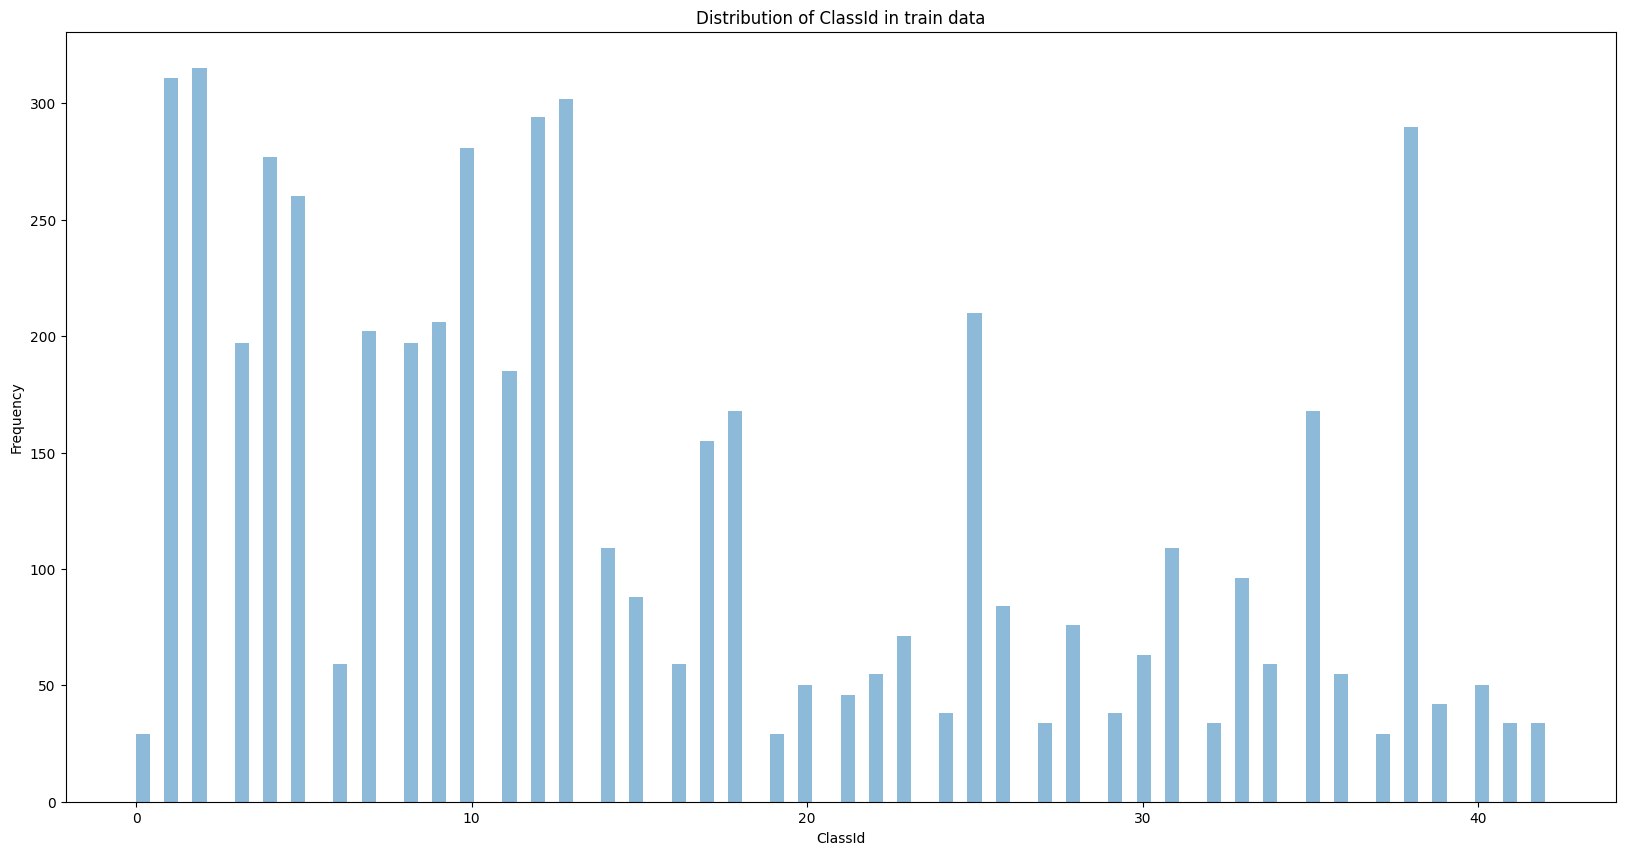

In [331]:
# do the same for test data?
import matplotlib.pyplot as plt
# lets look at the distribution of the test data:

plt.figure(figsize=(20, 10))
plt.hist(train_meta['ClassId'], bins=100, alpha=0.5, label='train')
plt.title('Distribution of ClassId in train data')
plt.xlabel('ClassId')
plt.ylabel('Frequency')

In [332]:
train_meta["ClassId"].value_counts()

ClassId
2     315
1     311
13    302
12    294
38    290
10    281
4     277
5     260
25    210
9     206
7     202
8     197
3     197
11    185
35    168
18    168
17    155
14    109
31    109
33     96
15     88
26     84
28     76
23     71
30     63
34     59
16     59
6      59
36     55
22     55
20     50
40     50
21     46
39     42
29     38
24     38
42     34
41     34
27     34
32     34
19     29
0      29
37     29
Name: count, dtype: int64

# Additional Feature extraction

## Shape Features

In [333]:
import cv2
import matplotlib.image as mpimg
import numpy as np

def extract_shape_features(img_path):
    img = mpimg.imread(img_path)

    if img.max() <= 1.0:
        img = (img * 255).astype(np.uint8)

    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    _, binary = cv2.threshold(gray, 60, 255, cv2.THRESH_BINARY)

    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if contours:
        largest = max(contours, key=cv2.contourArea)
        x, y, w, h = cv2.boundingRect(largest)

        # Aspect ratio
        aspect_ratio = float(w) / h

        # Extent (area / bounding box area)
        extent = cv2.contourArea(largest) / (w * h + 1e-6)

        # Solidity (area / convex hull area)
        hull = cv2.convexHull(largest)
        hull_area = cv2.contourArea(hull)
        solidity = cv2.contourArea(largest) / (hull_area + 1e-6)

        # Hu Moments (scale/rotation/translation invariant)
        moments = cv2.moments(largest)
        hu_moments = cv2.HuMoments(moments).flatten()

        # Log scale Hu moments to improve stability
        hu_moments = -np.sign(hu_moments) * np.log10(np.abs(hu_moments) + 1e-6)

        return [aspect_ratio, extent, solidity] + hu_moments.tolist()

    else:
        # If no contour found, return zeros
        return [0.0] * 10



for idx, row in train_df.iterrows():
    shape_feat = extract_shape_features(row["image_path"])
    for k, val in enumerate(shape_feat):
        train_df.at[idx, f'shape_feat_{k}'] = val

for idx, row in test_df.iterrows():
    img = mpimg.imread(row["image_path"])
    shape_feat = extract_shape_features(row["image_path"])
    for k, val in enumerate(shape_feat):
        test_df.at[idx, f'shape_feat_{k}'] = val


## HSV / LAB information

In [334]:
def extract_hsv_histogram(image_path, num_bins=4):
    # read the image
    image = cv2.imread(image_path)

    # Make image hsv
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    hist = cv2.calcHist([hsv_image], [0, 1, 2], None, [8, 4, 4], [0, 180, 0, 256, 0, 256])

    cv2.normalize(hist, hist)

    hist = hist.flatten()

    return hist

In [335]:
# Add mean HSV histogram as features for train
for idx, row in train_df.iterrows():
    hsv_feats = extract_hsv_histogram(row["image_path"])
    for k, val in enumerate(hsv_feats):
        train_df.at[idx, f'hsv_bin_{k}'] = val

# Add mean HSV histogram as features for test
for idx, row in test_df.iterrows():
    img = mpimg.imread(row["image_path"])
    hsv_feats = extract_hsv_histogram(row["image_path"])
    for k, val in enumerate(hsv_feats):
        test_df.at[idx, f'hsv_bin_{k}'] = val

/var/folders/f8/7bfj312x46n0l2_hr_xk_tdr0000gn/T/ipykernel_28892/205449982.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_df.at[idx, f'hsv_bin_{k}'] = val
/var/folders/f8/7bfj312x46n0l2_hr_xk_tdr0000gn/T/ipykernel_28892/205449982.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_df.at[idx, f'hsv_bin_{k}'] = val
/var/folders/f8/7bfj312x46n0l2_hr_xk_tdr0000gn/T/ipykernel_28892/205449982.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, whi

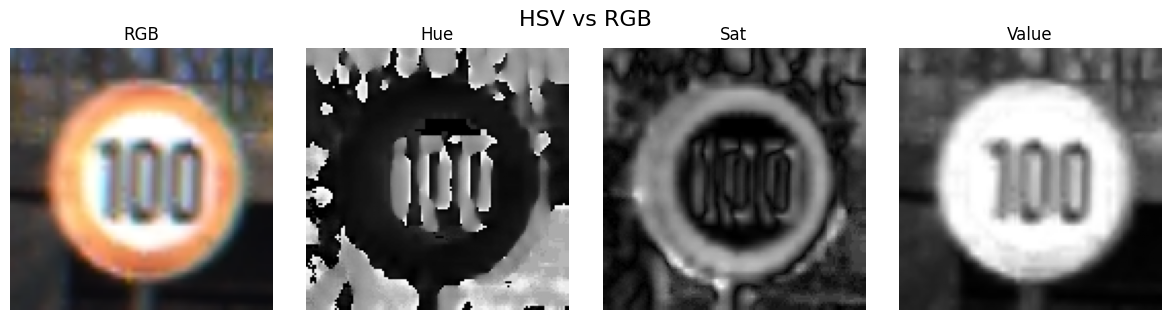

In [336]:
# quick visualization of the HSV histogram
import matplotlib.pyplot as plt
import cv2

image_path = train_df.iloc[2]["image_path"]

W = 128
H = 128

rgb = cv2.imread(image_path)
rgb = cv2.resize(rgb, (W, H))
rgb = cv2.cvtColor(rgb, cv2.COLOR_BGR2RGB)

hsv = cv2.cvtColor(rgb, cv2.COLOR_RGB2HSV)
Hc, Sc, Vc = cv2.split(hsv)

fig, axes = plt.subplots(1,4, figsize=(12,3))
axes[0].imshow(rgb)
axes[0].set_title('RGB')
axes[0].axis('off')
axes[1].imshow(Hc, cmap='gray')
axes[1].set_title('Hue') 
axes[1].axis('off')
axes[2].imshow(Sc, cmap='gray') 
axes[2].set_title('Sat')
axes[2].axis('off')
axes[3].imshow(Vc, cmap='gray')
axes[3].set_title('Value'); axes[3].axis('off')
plt.tight_layout()
plt.suptitle('HSV vs RGB', y = 1.05, fontsize=16)
plt.show()


## Edge Density

In [337]:
from scipy import ndimage
import numpy as np
import matplotlib.image as mpimg

# extracting the edge density of each of the images
# this is different from the information we get from the hog pca
# hog gives us the orientation of pixels but edge density gives us the "busyness"
# of the edges of the image, this seems useful for sign stuff

def get_ed(img_path):
    img = mpimg.imread(img_path)

    gx = ndimage.sobel(img, axis=1)               
    gy = ndimage.sobel(img, axis=0)               
    mag = np.hypot(gx, gy)
    edge_density = np.mean(mag > mag.mean())      

    return edge_density

train_df["ed"] = train_df["image_path"].apply(get_ed)
test_df["ed"] = test_df["image_path"].apply(get_ed)

/var/folders/f8/7bfj312x46n0l2_hr_xk_tdr0000gn/T/ipykernel_28892/3107467191.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_df["ed"] = train_df["image_path"].apply(get_ed)
/var/folders/f8/7bfj312x46n0l2_hr_xk_tdr0000gn/T/ipykernel_28892/3107467191.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_df["ed"] = test_df["image_path"].apply(get_ed)


## Colour variance and skew

In [338]:
# get the colour variance and skew per channel
# this is missing from the original features, they have means but not the other moments for colours
def get_color_stats(img_path):
    img = mpimg.imread(img_path)
    r, g, b = img[:, :, 0], img[:, :, 1], img[:, :, 2]

    r_var, g_var, b_var = np.var(r), np.var(g), np.var(b)
    r_skew, g_skew, b_skew = pd.Series(r.flatten()).skew(), pd.Series(g.flatten()).skew(), pd.Series(b.flatten()).skew()

    return r_var, g_var, b_var, r_skew, g_skew, b_skew

dfs = [train_df, test_df]
for df in dfs:
    for row in df.iterrows():
        r_var, g_var, b_var, r_skew, g_skew, b_skew = get_color_stats(row[1]["image_path"])
        df.at[row[0], "r_var"] = r_var
        df.at[row[0], "g_var"] = g_var
        df.at[row[0], "b_var"] = b_var
        df.at[row[0], "r_skew"] = r_skew
        df.at[row[0], "g_skew"] = g_skew
        df.at[row[0], "b_skew"] = b_skew

/var/folders/f8/7bfj312x46n0l2_hr_xk_tdr0000gn/T/ipykernel_28892/835917829.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.at[row[0], "r_var"] = r_var
/var/folders/f8/7bfj312x46n0l2_hr_xk_tdr0000gn/T/ipykernel_28892/835917829.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.at[row[0], "g_var"] = g_var
/var/folders/f8/7bfj312x46n0l2_hr_xk_tdr0000gn/T/ipykernel_28892/835917829.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor p

In [339]:
train_df

,image_path,ClassId,id,shape_feat_0,shape_feat_1,shape_feat_2,shape_feat_3,shape_feat_4,shape_feat_5,shape_feat_6,...,hsv_bin_125,hsv_bin_126,hsv_bin_127,ed,r_var,g_var,b_var,r_skew,g_skew,b_skew
0,train/img_000001.jpg,32,7218,0.950000,0.681579,0.959259,0.793945,3.832760,4.926251,5.982200,...,0.0,0.0,0.0,0.350694,0.021042,0.023334,0.026268,1.040953,1.098451,1.162215
1,train/img_000002.jpg,13,6333,1.076923,0.502747,0.920755,0.718636,4.795738,2.368078,5.751383,...,0.0,0.0,0.0,0.276162,0.018819,0.022255,0.030518,1.188856,1.860767,1.811297
2,train/img_000003.jpg,7,6867,1.061224,0.686617,0.888748,0.761528,3.123667,3.127995,4.607698,...,0.0,0.0,0.0,0.358059,0.110959,0.074273,0.059620,0.319793,0.439914,0.825414
3,train/img_000004.jpg,4,7730,0.952381,0.291667,0.386435,0.266064,1.565967,2.147781,2.241737,...,0.0,0.0,0.0,0.338162,0.004902,0.004954,0.006683,1.175130,1.781462,1.767261
4,train/img_000005.jpg,35,6338,1.000000,0.942042,1.000000,0.778149,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.335640,0.027111,0.019726,0.034961,2.044437,2.303106,0.882210
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5483,train/img_005484.jpg,17,456,0.541667,0.621795,0.801653,0.639761,1.605804,4.164367,4.516900,...,0.0,0.0,0.0,0.307802,0.143104,0.102539,0.101914,0.185874,0.833547,1.059753
5484,train/img_005485.jpg,4,4084,1.000000,0.949375,1.000000,0.778149,0.000000,6.000000,6.000000,...,0.0,0.0,0.0,0.346702,0.017843,0.019095,0.016943,1.616173,1.807669,1.412003
5485,train/img_005486.jpg,2,5117,1.000000,0.740593,0.817986,0.764279,2.770023,4.272735,5.717579,...,0.0,0.0,0.0,0.380046,0.123586,0.112273,0.133039,-0.681861,-0.210425,-0.017368
5486,train/img_005487.jpg,3,3334,1.186047,0.379161,0.415127,0.247501,1.188677,2.001601,1.943165,...,0.0,0.0,0.0,0.209412,0.099829,0.109881,0.115890,0.689945,0.665017,0.658464


## Local Binary Pattern (LBP)

In [340]:
from skimage.feature import local_binary_pattern
from skimage.util import view_as_windows

def extract_lbp_features(img, window_size=16, P=8, R=1, method='uniform'):
    """ Extract LBP features from an image."""
    lbp_map = local_binary_pattern(img, P=P, R=R, method=method)

    # normalises the LBP map to the range [0, n_bins-1]
    n_bins = int(lbp_map.max() + 1)  

    # reshape the image into patches for locality
    patches = view_as_windows(lbp_map, (window_size, window_size), step=window_size)
    nrows, ncols, _, _ = patches.shape

    lbp_feats = np.zeros((nrows, ncols, n_bins), dtype=float)

    # bin each patch and calculate the histogram
    for i in range(nrows):
        for j in range(ncols):
            patch = patches[i, j].ravel().astype(int)
            hist, _ = np.histogram(patch, bins=np.arange(n_bins+1), density=True)
            lbp_feats[i, j, :] = hist

    return lbp_feats

In [341]:
from skimage.feature import local_binary_pattern
from skimage.util import view_as_windows
from skimage import color

# Set your LBP parameters
P = 8
R = 1
METHOD = 'uniform'

# Compute the maximum number of bins for these parameters
dummy_img = np.zeros((16, 16), dtype=np.uint8)
lbp_map = local_binary_pattern(dummy_img, P=P, R=R, method=METHOD)
n_bins = int(lbp_map.max() + 1)

def extract_lbp_features_fixed_bins(img, window_size=16, P=8, R=1, method='uniform', n_bins=None):
    lbp_map = local_binary_pattern(img, P=P, R=R, method=method)
    patches = view_as_windows(lbp_map, (window_size, window_size), step=window_size)
    nrows, ncols, _, _ = patches.shape
    lbp_feats = np.zeros((nrows, ncols, n_bins), dtype=float)
    for i in range(nrows):
        for j in range(ncols):
            patch = patches[i, j].ravel().astype(int)
            hist, _ = np.histogram(patch, bins=np.arange(n_bins+1), density=True)
            lbp_feats[i, j, :] = hist
    return lbp_feats

# Add mean LBP histogram as features for train
for idx, row in train_df.iterrows():
    img = mpimg.imread(row["image_path"])
    img_gray = color.rgb2gray(img)
    img = (img_gray * 255).astype(np.uint8)
    lbp_feats = extract_lbp_features_fixed_bins(img, P=P, R=R, method=METHOD, n_bins=n_bins)
    mean_hist = lbp_feats.mean(axis=(0, 1))
    for k, val in enumerate(mean_hist):
        train_df.at[idx, f'lbp_bin_{k}'] = val

# Add mean LBP histogram as features for test
for idx, row in test_df.iterrows():
    img = mpimg.imread(row["image_path"])
    img_gray = color.rgb2gray(img)
    img = (img_gray * 255).astype(np.uint8)
    lbp_feats = extract_lbp_features_fixed_bins(img, P=P, R=R, method=METHOD, n_bins=n_bins)
    mean_hist = lbp_feats.mean(axis=(0, 1))
    for k, val in enumerate(mean_hist):
        test_df.at[idx, f'lbp_bin_{k}'] = val

/var/folders/f8/7bfj312x46n0l2_hr_xk_tdr0000gn/T/ipykernel_28892/1336237829.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_df.at[idx, f'lbp_bin_{k}'] = val
/var/folders/f8/7bfj312x46n0l2_hr_xk_tdr0000gn/T/ipykernel_28892/1336237829.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_df.at[idx, f'lbp_bin_{k}'] = val
/var/folders/f8/7bfj312x46n0l2_hr_xk_tdr0000gn/T/ipykernel_28892/1336237829.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many time

## HOG with PCA

In [342]:
import numpy as np
import pandas as pd
from skimage import color
from skimage.feature import hog
from sklearn.decomposition import PCA
import matplotlib.image as mpimg
from skimage.transform import resize

orientations     = 20
pixels_per_cell  = (8, 8)
cells_per_block  = (2, 2)
n_components     = 50  

def extract_hog_features(img):
    # Convert ot grayscale
    img = color.rgb2gray(img)
        
    # Resize image to a fixed size to ensure consistent HOG feature dimensions
    img = resize(img, (64, 64), anti_aliasing=True)

    return hog(
        img,
        orientations=orientations,
        pixels_per_cell=pixels_per_cell,
        cells_per_block=cells_per_block,
        block_norm='L2-Hys',
        visualize=False
    )

train_hog = []

# Extracting HOG features 
for i, path in enumerate(train_df["image_path"]):
    if i % 100 == 0:
        print(f"Processing train image {i}/{len(train_df)}")
    img = mpimg.imread(path)
    train_hog.append(extract_hog_features(img))
# adds to array row-wise
train_hog = np.vstack(train_hog)

test_hog = []
for i, path in enumerate(test_df["image_path"]):
    if i % 100 == 0:
        print(f"Processing test image {i}/{len(test_df)}")
    img = mpimg.imread(path)
    test_hog.append(extract_hog_features(img))
test_hog = np.vstack(test_hog)

max_comp = min(n_components, train_hog.shape[0], train_hog.shape[1])
if n_components > max_comp:
    print(f"Warning: reducing n_components from {n_components} to {max_comp}")
    n_components = max_comp

# Apply pca to extracted features
pca = PCA(n_components=n_components, svd_solver="auto")
train_pca = pca.fit_transform(train_hog)
test_pca  = pca.transform(test_hog)

# Add to dfs
for i in range(n_components):
    train_df[f"hog_pca_{i}"] = train_pca[:, i]
    test_df[f"hog_pca_{i}"]  = test_pca[:,  i]

Processing train image 0/5488
Processing train image 100/5488
Processing train image 200/5488
Processing train image 300/5488
Processing train image 400/5488
Processing train image 500/5488
Processing train image 600/5488
Processing train image 700/5488
Processing train image 800/5488
Processing train image 900/5488
Processing train image 1000/5488
Processing train image 1100/5488
Processing train image 1200/5488
Processing train image 1300/5488
Processing train image 1400/5488
Processing train image 1500/5488
Processing train image 1600/5488
Processing train image 1700/5488
Processing train image 1800/5488
Processing train image 1900/5488
Processing train image 2000/5488
Processing train image 2100/5488
Processing train image 2200/5488
Processing train image 2300/5488
Processing train image 2400/5488
Processing train image 2500/5488
Processing train image 2600/5488
Processing train image 2700/5488
Processing train image 2800/5488
Processing train image 2900/5488
Processing train image

/var/folders/f8/7bfj312x46n0l2_hr_xk_tdr0000gn/T/ipykernel_28892/456480632.py:61: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_df[f"hog_pca_{i}"] = train_pca[:, i]
/var/folders/f8/7bfj312x46n0l2_hr_xk_tdr0000gn/T/ipykernel_28892/456480632.py:62: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_df[f"hog_pca_{i}"]  = test_pca[:,  i]
/var/folders/f8/7bfj312x46n0l2_hr_xk_tdr0000gn/T/ipykernel_28892/456480632.py:61: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many

# Train Val split

In [411]:
len(test_df.columns) # 207 features extracted

207

In [412]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA

# The features we're interested in
FEATURES = [c for c in train_df.columns if c not in ("id", "image_path", "ClassId", "Shape")]

# Scale the data (NOTE: its important to scale the train subset and validation together and the whole of )
X_train_full = train_df[FEATURES]
X_test = test_df[FEATURES]
y_train_full = train_df["ClassId"]

scaler = StandardScaler().fit(X_train_full)
X_train_full_scaled = scaler.transform(X_train_full)
X_train_full_scaled = pd.DataFrame(X_train_full_scaled, columns=FEATURES, index=train_df.index)

X_test_scaled = scaler.transform(X_test)
scaled_train_df = pd.DataFrame(X_train_full_scaled, columns=FEATURES, index=train_df.index)
scaled_test_df  = pd.DataFrame(X_test_scaled, columns=FEATURES, index=test_df.index)
X_test_scaled = scaled_test_df

# Split indices instead of data directly
train_idx, val_idx = train_test_split(
    scaled_train_df.index,
    test_size=0.1,
    random_state=1,
    stratify=y_train_full
)

# Experimented with PCA, but it didn't seem to help much
do_pca = False

train_df_val = train_df.loc[val_idx]

X_train = pd.DataFrame(scaler.fit_transform(train_df.loc[train_idx][FEATURES]), columns=FEATURES, index = train_df.loc[train_idx].index)
X_val = pd.DataFrame(scaler.transform(train_df.loc[val_idx][FEATURES]), columns=FEATURES, index = train_df.loc[val_idx].index)

y_train = y_train_full.loc[train_idx]
y_val = y_train_full.loc[val_idx]

if do_pca:
    pca = PCA(n_components=50)

    X_train = pd.DataFrame(scaler.fit_transform(train_df.loc[train_idx][FEATURES]), columns=FEATURES, index = train_df.loc[train_idx].index)
    X_val = pd.DataFrame(scaler.fit_transform(train_df.loc[val_idx][FEATURES]), columns=FEATURES, index = train_df.loc[val_idx].index)
    y_train = y_train_full.loc[train_idx]
    y_val = y_train_full.loc[val_idx]
    X_train = pd.DataFrame(pca.fit_transform(X_train), index=train_idx, columns=[f'pca_{i}' for i in range(pca.n_components_)])
    X_val = pd.DataFrame(pca.transform(X_val), index=val_idx, columns=[f'pca_{i}' for i in range(pca.n_components_)])
    X_train_full_scaled = pd.DataFrame(pca.fit_transform(X_train_full_scaled), index=train_df.index, columns=[f'pca_{i}' for i in range(pca.n_components_)])
    X_test_scaled = pd.DataFrame(pca.fit_transform(X_test_scaled), index=test_df.index, columns=[f'pca_{i}' for i in range(pca.n_components_)])


# Post feature extraction Check

In [352]:
# Sanity check
assert set(X_train.columns).difference(set(test_df.columns)) == set()
assert set(X_train.columns).difference(set(train_df.columns)) == set()

In [353]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((4939, 204), (4939,), (549, 204), (549,))

# Training Machine learning models

## SVM

In [413]:
for col in train_df.columns:
    print(col)

image_path
ClassId
id
shape_feat_0
shape_feat_1
shape_feat_2
shape_feat_3
shape_feat_4
shape_feat_5
shape_feat_6
shape_feat_7
shape_feat_8
shape_feat_9
hsv_bin_0
hsv_bin_1
hsv_bin_2
hsv_bin_3
hsv_bin_4
hsv_bin_5
hsv_bin_6
hsv_bin_7
hsv_bin_8
hsv_bin_9
hsv_bin_10
hsv_bin_11
hsv_bin_12
hsv_bin_13
hsv_bin_14
hsv_bin_15
hsv_bin_16
hsv_bin_17
hsv_bin_18
hsv_bin_19
hsv_bin_20
hsv_bin_21
hsv_bin_22
hsv_bin_23
hsv_bin_24
hsv_bin_25
hsv_bin_26
hsv_bin_27
hsv_bin_28
hsv_bin_29
hsv_bin_30
hsv_bin_31
hsv_bin_32
hsv_bin_33
hsv_bin_34
hsv_bin_35
hsv_bin_36
hsv_bin_37
hsv_bin_38
hsv_bin_39
hsv_bin_40
hsv_bin_41
hsv_bin_42
hsv_bin_43
hsv_bin_44
hsv_bin_45
hsv_bin_46
hsv_bin_47
hsv_bin_48
hsv_bin_49
hsv_bin_50
hsv_bin_51
hsv_bin_52
hsv_bin_53
hsv_bin_54
hsv_bin_55
hsv_bin_56
hsv_bin_57
hsv_bin_58
hsv_bin_59
hsv_bin_60
hsv_bin_61
hsv_bin_62
hsv_bin_63
hsv_bin_64
hsv_bin_65
hsv_bin_66
hsv_bin_67
hsv_bin_68
hsv_bin_69
hsv_bin_70
hsv_bin_71
hsv_bin_72
hsv_bin_73
hsv_bin_74
hsv_bin_75
hsv_bin_76
hsv_bin_77


In [414]:
from sklearn.experimental import enable_halving_search_cv 
from sklearn.model_selection import RandomizedSearchCV, HalvingGridSearchCV
from scipy.stats import loguniform
from sklearn.svm import SVC

# Randomized search for a broad region
rnd = RandomizedSearchCV(
    SVC(),
    param_distributions={
        'C': loguniform(1e-1, 1e2),
        'gamma': loguniform(1e-4, 1),
        'kernel': ['linear', 'rbf', 'poly']
    },
    n_iter=10,
    n_jobs=-1,
    random_state=42,
    verbose=2
)
rnd.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END C=1.3292918943162166, gamma=0.6351221010640696, kernel=poly; total time=   2.9s
[CV] END C=1.3292918943162166, gamma=0.6351221010640696, kernel=poly; total time=   3.0s
[CV] END C=1.3292918943162166, gamma=0.6351221010640696, kernel=poly; total time=   3.1s
[CV] END C=1.3292918943162166, gamma=0.6351221010640696, kernel=poly; total time=   3.1s
[CV] END C=1.3292918943162166, gamma=0.6351221010640696, kernel=poly; total time=   3.1s
[CV] END C=21.830968390524596, gamma=0.024400607090817518, kernel=rbf; total time=   3.5s
[CV] END C=21.830968390524596, gamma=0.024400607090817518, kernel=rbf; total time=   3.6s
[CV] END C=21.830968390524596, gamma=0.024400607090817518, kernel=rbf; total time=   3.7s
[CV] END C=21.830968390524596, gamma=0.024400607090817518, kernel=rbf; total time=   3.7s
[CV] END C=21.830968390524596, gamma=0.024400607090817518, kernel=rbf; total time=   3.7s
[CV] END C=0.2937538457632829, gamma=0.00017

RandomizedSearchCV(estimator=SVC(), n_jobs=-1,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x328d07d10>,
                                        'gamma': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x32b3380d0>,
                                        'kernel': ['linear', 'rbf', 'poly']},
                   random_state=42, verbose=2)

In [415]:
# Focused halving search around the best found
best = rnd.best_params_
grid_fine = {
    'C': [best['C'] * f for f in [0.5, 1, 2]],
    'gamma': [best['gamma'] * f for f in [0.5, 1, 2]],
    'kernel': ['linear', 'rbf', 'sigmoid', 'poly']
}

In [416]:
# Smaller fine-grained search
halving = HalvingGridSearchCV(
    SVC(),
    grid_fine,
    factor=2,
    resource='n_samples',
    max_resources='auto',
    n_jobs=-1,
    verbose=2
)
halving.fit(X_train, y_train)

svm_model = halving.best_estimator_

print("Final best params:", halving.best_params_)

n_iterations: 4
n_required_iterations: 6
n_possible_iterations: 4
min_resources_: 430
max_resources_: 4939
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 36
n_resources: 430
Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV] END C=0.14687692288164145, gamma=8.53698371576406e-05, kernel=linear; total time=   0.0s
[CV] END C=0.14687692288164145, gamma=8.53698371576406e-05, kernel=linear; total time=   0.0s
[CV] END C=0.14687692288164145, gamma=8.53698371576406e-05, kernel=linear; total time=   0.0s
[CV] END C=0.14687692288164145, gamma=8.53698371576406e-05, kernel=linear; total time=   0.0s
[CV] END C=0.14687692288164145, gamma=8.53698371576406e-05, kernel=linear; total time=   0.0s
[CV] END C=0.14687692288164145, gamma=8.53698371576406e-05, kernel=rbf; total time=   0.0s
[CV] END C=0.14687692288164145, gamma=8.53698371576406e-05, kernel=sigmoid; total time=   0.0s
[CV] END C=0.14687692288164145, gamma=8.53698371576406e-05, kernel=rbf; total time

In [417]:
from sklearn.metrics import classification_report
y_pred = svm_model.predict(X_val)

report = classification_report(y_val, y_pred)
print(report)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       0.88      0.90      0.89        31
           2       0.79      0.81      0.80        32
           3       0.86      0.95      0.90        20
           4       0.93      1.00      0.97        28
           5       0.73      0.62      0.67        26
           6       1.00      1.00      1.00         6
           7       0.81      0.85      0.83        20
           8       0.82      0.90      0.86        20
           9       0.95      1.00      0.98        21
          10       0.96      0.86      0.91        28
          11       0.83      1.00      0.90        19
          12       1.00      1.00      1.00        29
          13       1.00      1.00      1.00        30
          14       1.00      1.00      1.00        11
          15       1.00      0.89      0.94         9
          16       1.00      1.00      1.00         6
          17       1.00    

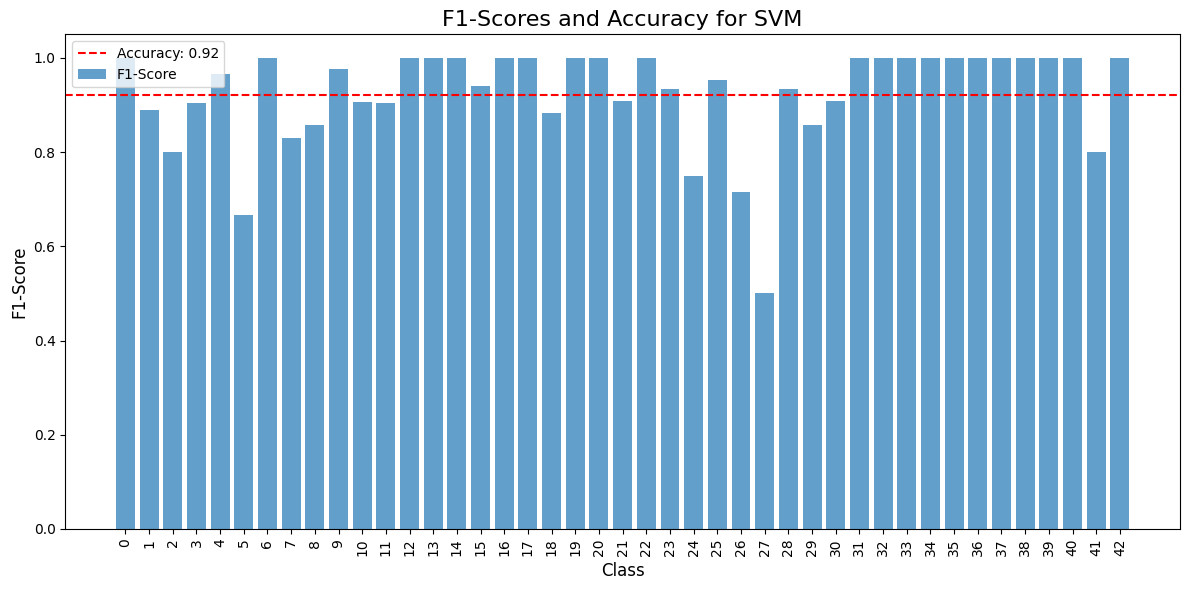

In [418]:
from sklearn.metrics import classification_report
import numpy as np
import matplotlib.pyplot as plt

y_pred = svm_model.predict(X_val)

report = classification_report(y_val, y_pred, output_dict=True)

# Extract accuracy and F1-scores
accuracy = report["accuracy"]
f1_scores = [v["f1-score"] for k, v in report.items() if k.isdigit()]

# Plot F1-scores
plt.figure(figsize=(12, 6))
plt.bar(range(len(f1_scores)), f1_scores, alpha=0.7, label='F1-Score')
plt.axhline(y=accuracy, color='r', linestyle='--', label=f'Accuracy: {accuracy:.2f}')
plt.title("F1-Scores and Accuracy for SVM", fontsize=16)
plt.xlabel("Class", fontsize=12)
plt.ylabel("F1-Score", fontsize=12)
plt.xticks(range(len(f1_scores)), [k for k in report.keys() if k.isdigit()], rotation=90)
plt.legend()
plt.tight_layout()
plt.show()


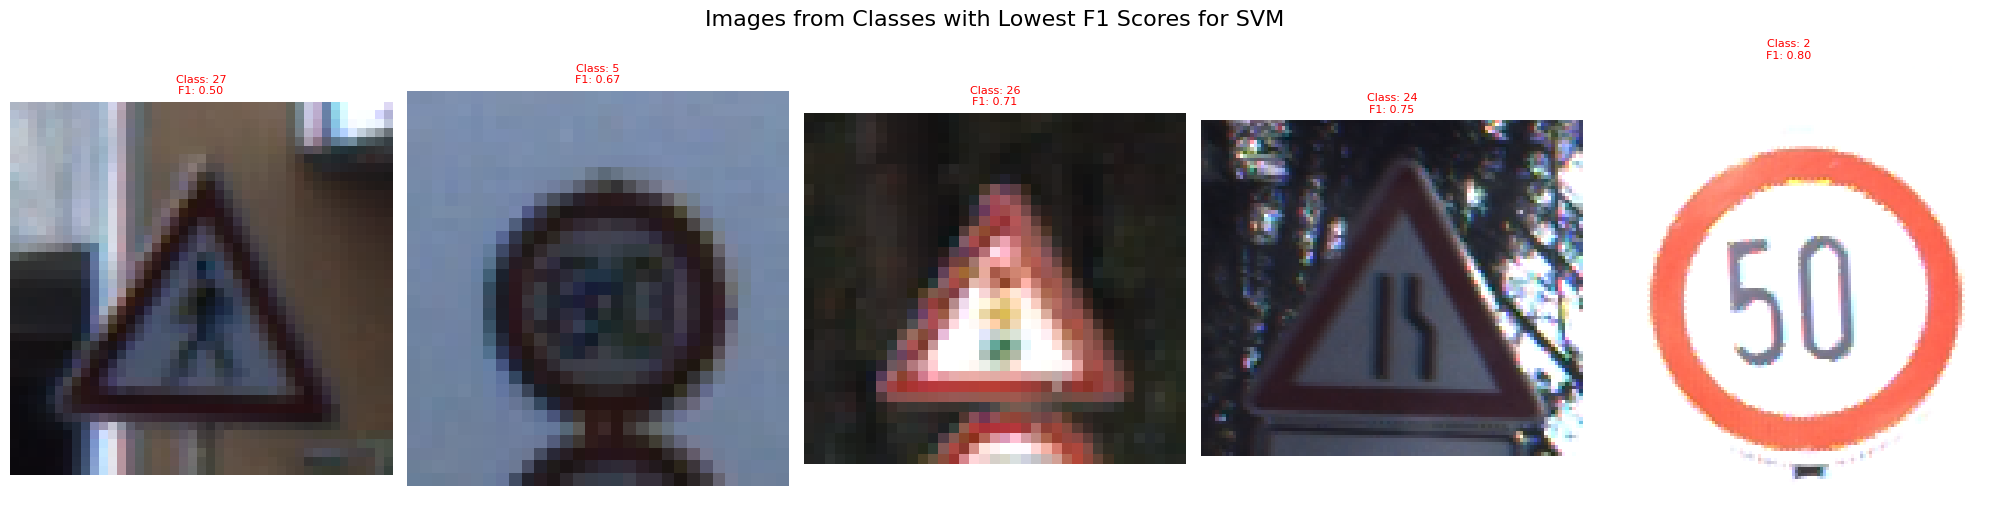

In [419]:
from sklearn.metrics import classification_report
import numpy as np
from skimage import io
import matplotlib.pyplot as plt

report = classification_report(y_val, y_pred, output_dict=True)

# extracts F1-scores and sort by lowest scores
f1_scores = {k: v["f1-score"] for k, v in report.items() if k.isdigit()}
lowest_f1_classes = sorted(f1_scores, key=f1_scores.get)[:5]  # Get 5 classes with lowest F1 scores

# Chose a random image from each of the classes with lowest F1 scores
# to understand what the error is
selected_images = []
for cls in lowest_f1_classes:
    class_images = train_df_val[train_df_val["ClassId"] == int(cls)]
    if not class_images.empty:
        selected_images.append(class_images.iloc[0])  # Select the first image from the class

n_plot = len(selected_images)
fig, axes = plt.subplots(1, n_plot, figsize=(20, 10))

for ax, row in zip(axes, selected_images):
    img = io.imread(row["image_path"])
    ax.imshow(img)
    ax.set_title(f"Class: {row['ClassId']}\nF1: {f1_scores[str(row['ClassId'])]:.2f}", fontsize=8, color="red")
    ax.axis("off")

plt.suptitle("Images from Classes with Lowest F1 Scores for SVM\n", fontsize=16, y=0.75)
plt.tight_layout()
plt.show()

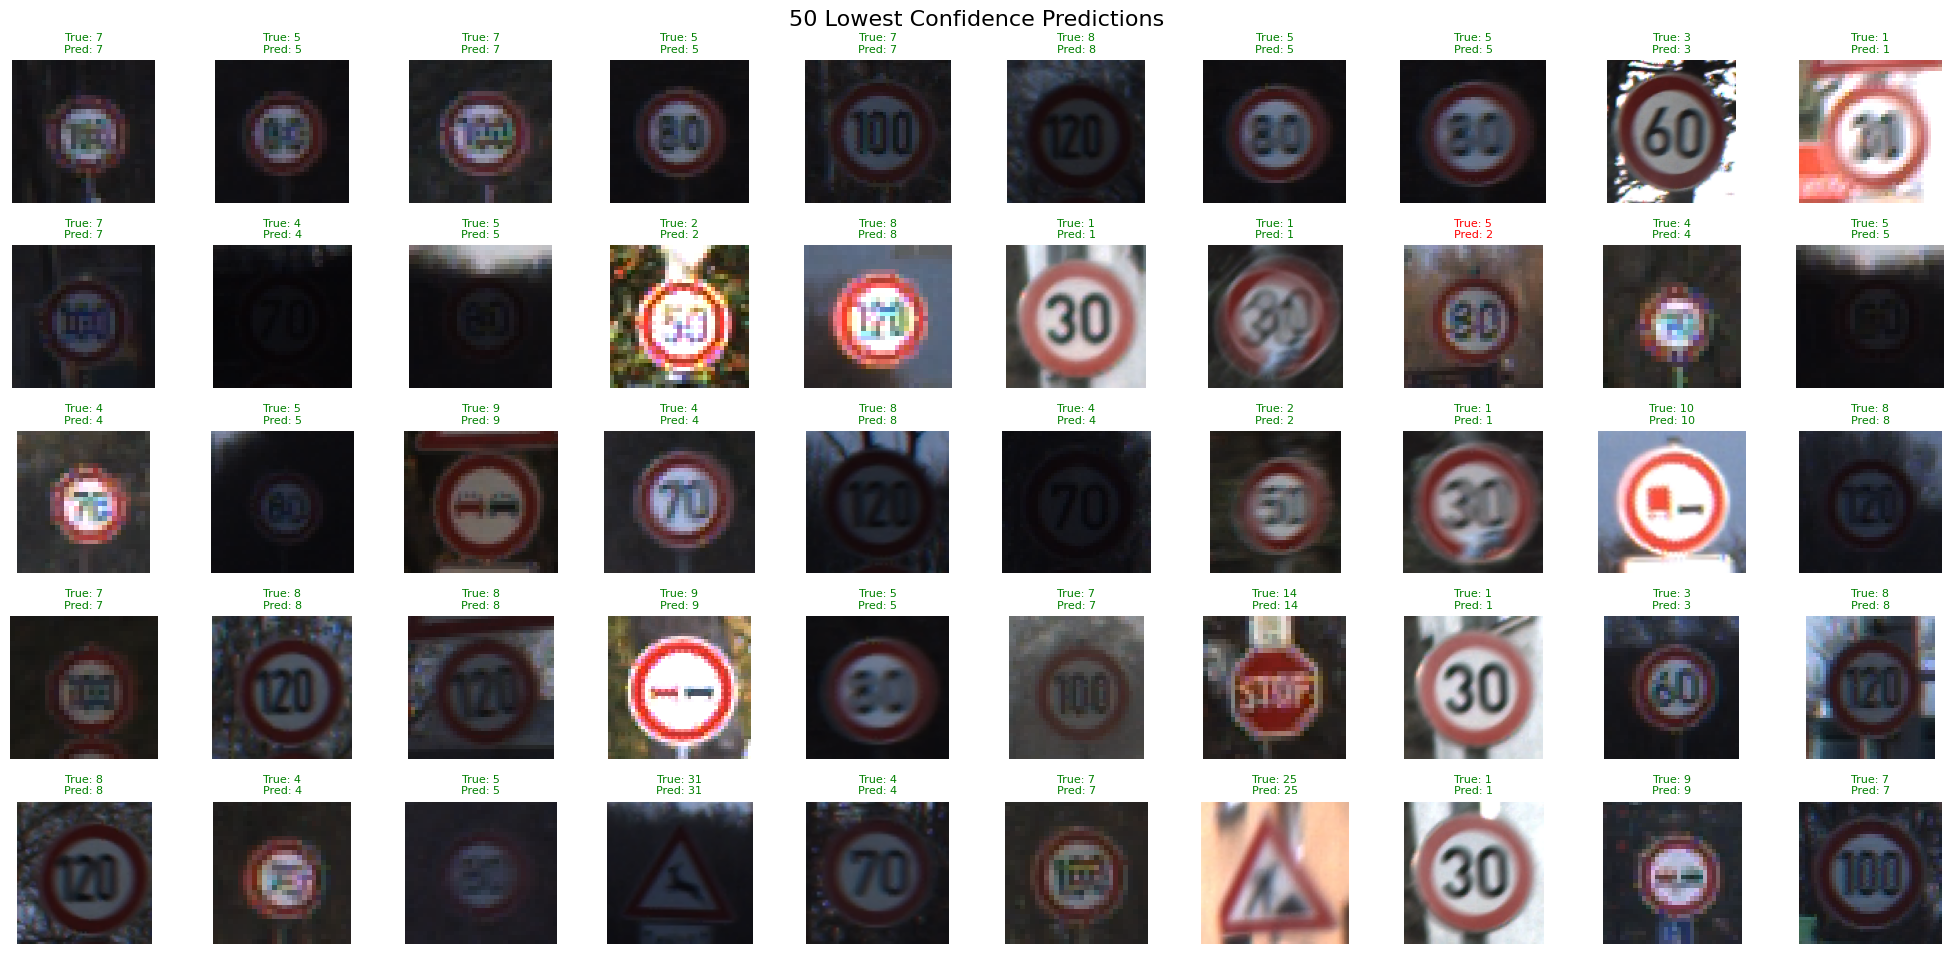

In [420]:
# Find the least confidently classified images
from skimage import io
import matplotlib.pyplot as plt

dists = [(i, val) for i, val in enumerate(np.sum(halving.decision_function(X_train), axis=1))]
dists.sort(key=lambda x: x[1], reverse=False)

fig, axes = plt.subplots(5, 10, figsize=(20, 10))
axes = axes.flatten()

# get indices of 50 lowest confidence predictions
worst_indx = [i for i, val in dists[:50]]
vals = X_train.iloc[worst_indx].index

# What was predicted for these samples?
predictions = halving.predict(X_train.iloc[worst_indx])

# Plot these images with titles
for i, (pth, ax) in enumerate(zip(train_df.iloc[vals]["image_path"], axes)):
    myimg = io.imread(pth)
    ax.imshow(myimg)
    true_label = y_train[vals[i]]
    pred_label = predictions[i]
    is_correct = true_label == pred_label
    color = 'green' if is_correct else 'red'
    ax.set_title(f'True: {true_label}\nPred: {pred_label}',
                 fontsize=8, color=color)
    ax.axis('off')

plt.suptitle('50 Lowest Confidence Predictions\n', fontsize=16, y=0.95)
plt.tight_layout()
plt.show()

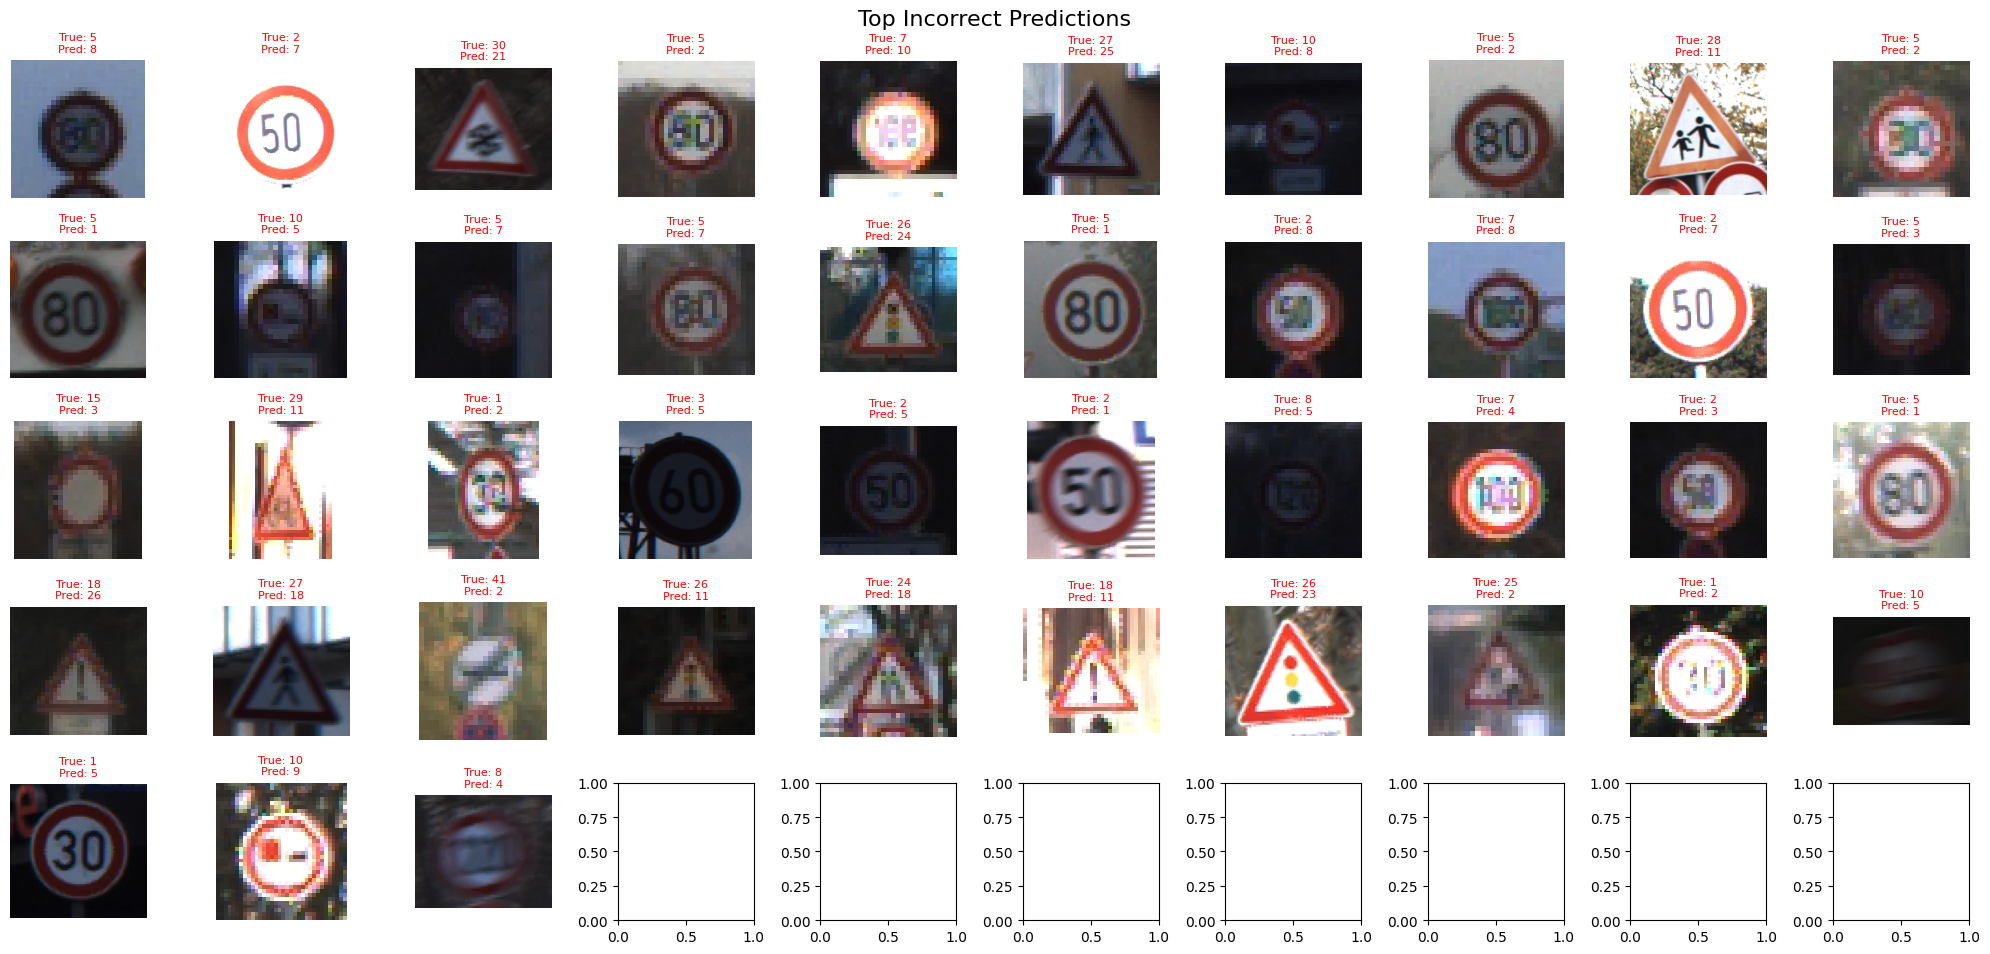

In [421]:
# Visualize the actually incorrect predictions
import matplotlib.pyplot as plt
from skimage import io
import pandas as pd

train_df_val = train_df.iloc[val_idx][["image_path", "ClassId"]].reset_index(drop=True)

val_predictions = svm_model.predict(X_val)

wrong_indices = [i for i, (t, p) in enumerate(zip(y_val, val_predictions)) if t != p]
n_plot = min(len(wrong_indices), 50)

fig, axes = plt.subplots(5, 10, figsize=(20, 10))
axes = axes.flatten()

for ax, idx in zip(axes, wrong_indices[:n_plot]):
    row = train_df_val.loc[idx]                
    img = io.imread(row["image_path"])         
    ax.imshow(img)
    ax.set_title(
        f"True: {row['ClassId']}\nPred: {val_predictions[idx]}",
        fontsize=8, color="red"
    )
    ax.axis("off")

plt.suptitle("Top Incorrect Predictions\n", fontsize=16, y=0.95)
plt.tight_layout()
plt.show()

## Logistic Regression

In [422]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

pipe = Pipeline([
    ('classifier', LogisticRegression(
        max_iter=500,
        multi_class="multinomial",
        random_state=42,
        penalty="l2",  
        solver="lbfgs", 
    ))
])

# Evaluate model with cross-validation
cv_scores = cross_val_score(pipe, X_train, y_train, cv=3, scoring='accuracy')
print(f"Cross-validation scores: {cv_scores}")
print(f"Mean CV accuracy: {cv_scores.mean():.3f} (+/- {cv_scores.std() * 2:.3f})")

# Train final model on full training set
pipe.fit(X_train, y_train)

# Evaluate on validation set
y_pred = pipe.predict(X_val)
val_accuracy = accuracy_score(y_val, y_pred)
print(f"Validation accuracy: {val_accuracy:.3f}")

lr_model = pipe.named_steps["classifier"]

/Users/duncanjcartwright/Documents/uni_stuff/year3/ML/assignments/ass2/tf-metal/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/duncanjcartwright/Documents/uni_stuff/year3/ML/assignments/ass2/tf-metal/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/duncanjcartwright/Documents/uni_stuff/year3/ML/assignments/ass2/tf-metal/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it

Cross-validation scores: [0.88767456 0.87545565 0.88456865]
Mean CV accuracy: 0.883 (+/- 0.010)


/Users/duncanjcartwright/Documents/uni_stuff/year3/ML/assignments/ass2/tf-metal/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Validation accuracy: 0.900


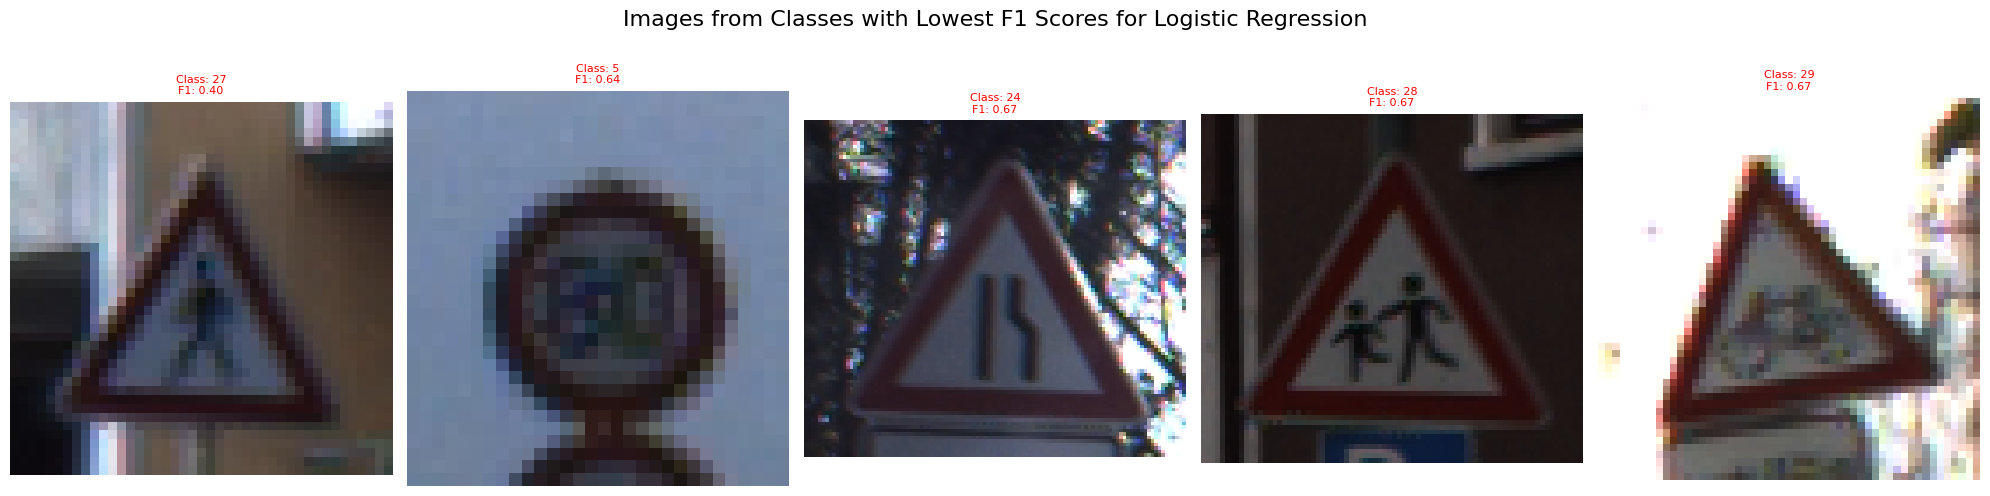

In [423]:
from sklearn.metrics import classification_report
import numpy as np
from skimage import io
import matplotlib.pyplot as plt

report = classification_report(y_val, y_pred, output_dict=True)

f1_scores = {k: v["f1-score"] for k, v in report.items() if k.isdigit()}
lowest_f1_classes = sorted(f1_scores, key=f1_scores.get)[:5]  # Get 5 classes with lowest F1 scores

# select one image from each class with the lowest F1 scores
selected_images = []
for cls in lowest_f1_classes:
    class_images = train_df_val[train_df_val["ClassId"] == int(cls)]
    if not class_images.empty:
        selected_images.append(class_images.iloc[0])  # Select the first image from the class

n_plot = len(selected_images)
fig, axes = plt.subplots(1, n_plot, figsize=(20, 10))

for ax, row in zip(axes, selected_images):
    img = io.imread(row["image_path"])
    ax.imshow(img)
    ax.set_title(f"Class: {row['ClassId']}\nF1: {f1_scores[str(row['ClassId'])]:.2f}", fontsize=8, color="red")
    ax.axis("off")

plt.suptitle("Images from Classes with Lowest F1 Scores for Logistic Regression\n", fontsize=16, y=0.75)
plt.tight_layout()
plt.show()

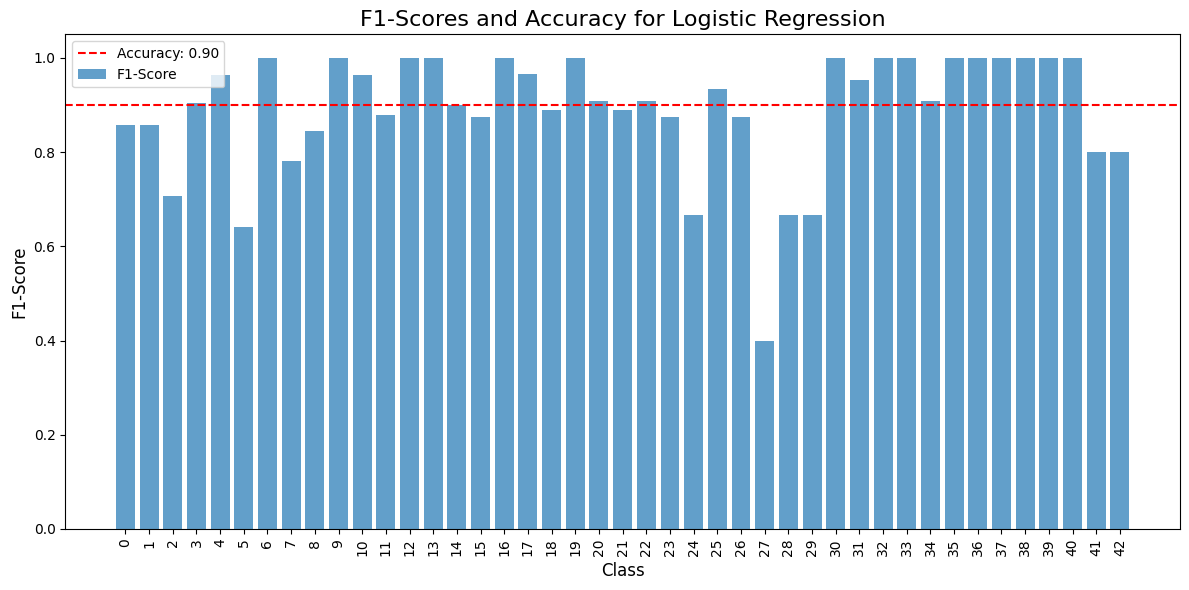

In [424]:
from sklearn.metrics import classification_report
import numpy as np
import matplotlib.pyplot as plt

report = classification_report(y_val, y_pred, output_dict=True)

# Extract accuracy and F1-scores
accuracy = report["accuracy"]
f1_scores = [v["f1-score"] for k, v in report.items() if k.isdigit()]

plt.figure(figsize=(12, 6))
plt.bar(range(len(f1_scores)), f1_scores, alpha=0.7, label='F1-Score')
plt.axhline(y=accuracy, color='r', linestyle='--', label=f'Accuracy: {accuracy:.2f}')
plt.title("F1-Scores and Accuracy for Logistic Regression", fontsize=16)
plt.xlabel("Class", fontsize=12)
plt.ylabel("F1-Score", fontsize=12)
plt.xticks(range(len(f1_scores)), [k for k in report.keys() if k.isdigit()], rotation=90)
plt.legend()
plt.tight_layout()
plt.show()


## KNN

In [425]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

# parameter grid
param_grid = {
    'n_neighbors': range(1, 31, 2),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

knn = KNeighborsClassifier()

grid_search = GridSearchCV(
    estimator=knn,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

# Fit the model
grid_search.fit(X_train, y_train)

# Print the best parameters and best score
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation accuracy: {grid_search.best_score_:.4f}")

# Evaluate on the validation set
best_knn = grid_search.best_estimator_
y_pred = best_knn.predict(X_val)
val_accuracy = accuracy_score(y_val, y_pred)
print(f"Validation accuracy: {val_accuracy:.4f}")

knn_model = best_knn

Fitting 5 folds for each of 90 candidates, totalling 450 fits
Best parameters: {'metric': 'manhattan', 'n_neighbors': 1, 'weights': 'uniform'}
Best cross-validation accuracy: 0.8647
Validation accuracy: 0.8871


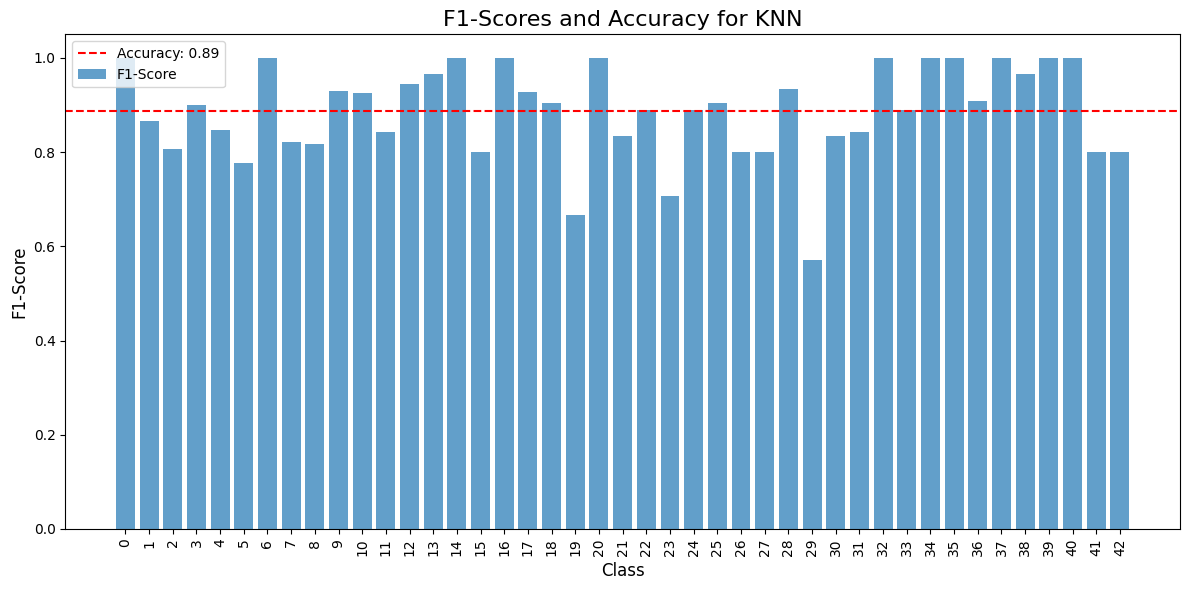

In [426]:
from sklearn.metrics import classification_report
import numpy as np
import matplotlib.pyplot as plt

y_pred = knn_model.predict(X_val)

report = classification_report(y_val, y_pred, output_dict=True)

accuracy = report["accuracy"]
f1_scores = [v["f1-score"] for k, v in report.items() if k.isdigit()]

plt.figure(figsize=(12, 6))
plt.bar(range(len(f1_scores)), f1_scores, alpha=0.7, label='F1-Score')
plt.axhline(y=accuracy, color='r', linestyle='--', label=f'Accuracy: {accuracy:.2f}')
plt.title("F1-Scores and Accuracy for KNN", fontsize=16)
plt.xlabel("Class", fontsize=12)
plt.ylabel("F1-Score", fontsize=12)
plt.xticks(range(len(f1_scores)), [k for k in report.keys() if k.isdigit()], rotation=90)
plt.legend()
plt.tight_layout()
plt.show()

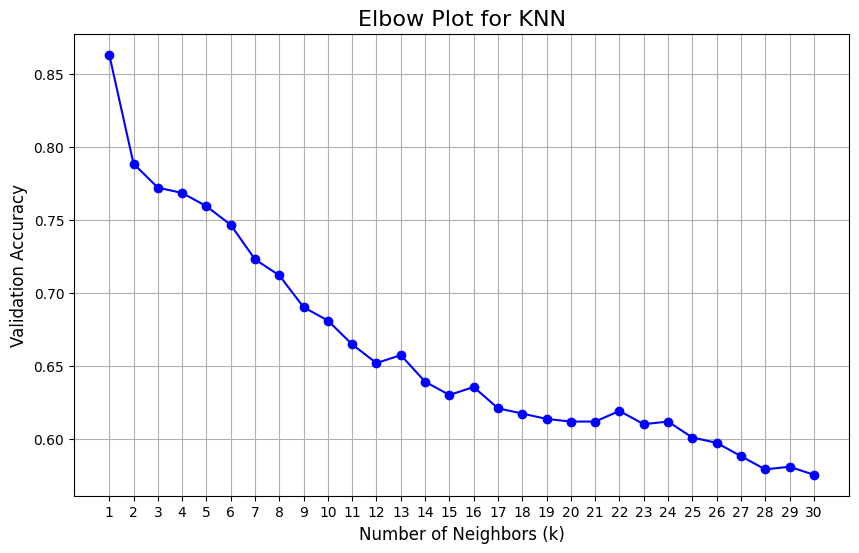

In [427]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

k_values = range(1, 31)

validation_accuracies = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_val_pred = knn.predict(X_val)
    accuracy = accuracy_score(y_val, y_val_pred)  # Calculate validation accuracy
    validation_accuracies.append(accuracy)

# Plot the elbow curve
plt.figure(figsize=(10, 6))
plt.plot(k_values, validation_accuracies, marker='o', linestyle='-', color='b')
plt.title('Elbow Plot for KNN', fontsize=16)
plt.xlabel('Number of Neighbors (k)', fontsize=12)
plt.ylabel('Validation Accuracy', fontsize=12)
plt.xticks(k_values)
plt.grid()
plt.show()


In [ ]:
# old T-SNE visualization code
# import numpy as np
# from sklearn.manifold import TSNE
# import matplotlib.pyplot as plt
# import time

# sample_size = 2000
# use_tsne = True

# if 'train_hog_pca' in globals():
#     X_train = train_hog_pca.drop('image_path', axis=1)
#     X_train_sample = X_train.sample(n=min(sample_size, len(X_train)), random_state=42)
#     y_train_sample = y_train_full.loc[X_train_sample.index]
    
#     X_val = X_train.loc[val_idx]
#     X_val_sample = X_val.sample(n=min(200, len(X_val)), random_state=42)
#     y_val_sample = y_train_full.loc[X_val_sample.index]
# else:
#     X_train_sample = X_train.sample(n=min(sample_size, len(X_train)), random_state=42)
#     y_train_sample = y_train.loc[X_train_sample.index]
    
#     X_val_sample = X_val.sample(n=min(200, len(X_val)), random_state=42)
#     y_val_sample = y_val.loc[X_val_sample.index]

# fig, ax = plt.subplots(figsize=(12, 10))

# if use_tsne:
#     print("Applying t-SNE...")
#     start_time = time.time()
    
#     tsne = TSNE(
#         n_components=2, 
#         perplexity=30,
#         n_iter=1000,
#         random_state=42
#     )
    
#     # Combine data for visualization
#     combined_data = np.vstack([X_train_sample.values, X_val_sample.values])
#     combined_labels = np.concatenate([y_train_sample, y_val_sample])
    
#     # Apply t-SNE
#     combined_tsne = tsne.fit_transform(combined_data)
    
#     X_train_tsne = combined_tsne[:len(X_train_sample)]
#     X_val_tsne = combined_tsne[len(X_train_sample):]
    
#     unique_classes = np.unique(combined_labels)
#     colors = plt.cm.tab20(np.linspace(0, 1, len(unique_classes)))
    
#     for cls, color in zip(unique_classes, colors):
#         train_idx = y_train_sample == cls
#         ax.scatter(
#             X_train_tsne[train_idx, 0], 
#             X_train_tsne[train_idx, 1], 
#             c=[color], 
#             label=f'Class {cls}', 
#             alpha=0.7, 
#             s=30
#         )
        
#     ax.set_title('t-SNE Visualization of Traffic Sign Dataset', fontsize=16)
#     ax.set_xlabel('t-SNE Dimension 1', fontsize=14)
#     ax.set_ylabel('t-SNE Dimension 2', fontsize=14)
    
#     ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), 
#             ncol=5, fontsize=8)

# plt.tight_layout()
# plt.show()

## Stacking

In [429]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
        n_estimators=300, max_depth=20, n_jobs=-1, random_state=42, class_weight='balanced_subsample')
rf.fit(X_train, y_train)
preds = rf.predict(X_val)
accuracy_score(y_val, preds)

0.8688524590163934

In [430]:
svm = SVC(
        kernel='rbf', C=10, gamma='scale', probability=True, random_state=42
    )
rf = svm
rf.fit(X_train, y_train)
preds = rf.predict(X_val)
accuracy_score(y_val, preds)

0.9198542805100182

In [431]:
lr = LogisticRegression(
        max_iter=500, solver='lbfgs', C=3, random_state=42
    )

rf = lr
rf.fit(X_train, y_train)
preds = rf.predict(X_val)
accuracy_score(y_val, preds)

0.8925318761384335

In [432]:
X_train.shape, y_train.shape

((4939, 204), (4939,))

In [433]:
# using pre-trained models
# Stacking: strong, simple, and explainable for tabular/computer vision features

from sklearn.ensemble import StackingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold

base_estimators = [
    ('rf', RandomForestClassifier(
        n_estimators=300, max_depth=20, n_jobs=-1, random_state=42, class_weight='balanced_subsample'
    )),
    ('svm_rbf',  svm_model),
    ('lr', lr_model),
]

meta_learner = RandomForestClassifier(
    n_estimators=500, max_depth=10, n_jobs=-1, random_state=42, class_weight='balanced_subsample'
)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

stacking = StackingClassifier(
    estimators=base_estimators,
    final_estimator=meta_learner,
    cv=cv,
    n_jobs=-1,
    passthrough=True
)

stacking.fit(X_train, y_train)

val_preds = stacking.predict(X_val)
val_acc = accuracy_score(y_val, val_preds)
print(f"Validation accuracy: {val_acc:.5f}")

/Users/duncanjcartwright/Documents/uni_stuff/year3/ML/assignments/ass2/tf-metal/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/duncanjcartwright/Documents/uni_stuff/year3/ML/assignments/ass2/tf-metal/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/duncanjcartwright/Documents/uni_stuff/year3/ML/assignments/ass2/tf-metal/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it

Validation accuracy: 0.92350


In [ ]:
# Stacking: strong, simple, and explainable for tabular/computer vision features

from sklearn.ensemble import StackingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold

base_estimators = [
    ('rf', RandomForestClassifier(
        n_estimators=300, max_depth=20, n_jobs=-1, random_state=42, class_weight='balanced_subsample'
    )),
    ('svm_rbf',  SVC(
        kernel='rbf', C=10, gamma='scale', probability=True, random_state=42
    )),
    ('lr', LogisticRegression(
        max_iter=500, solver='lbfgs', C=3, random_state=42
    )),
]

# base_estimators = [
#     # Random Forest: robust, handles many features well
#     ('rf', RandomForestClassifier(
#         n_estimators=300, max_depth=20, n_jobs=-1, random_state=42, class_weight='balanced_subsample'
#     )),
#     # SVM (RBF): strong for high-dimensional, non-linear data
#     # ('svm_rbf',  SVC(
#     #     kernel='linear', C=41.71, gamma=0.0008532678095658728, probability=True, random_state=42
#     # )),
#     ('svm_rbf',  svm_model),
#     # Logistic Regression: simple, interpretable linear model
#     ('lr', lr_model),
#     # ('mlp', mlp_model)
# ]

# Meta-learner: Random Forest (robust, non-linear, interpretable feature importances)
meta_learner = RandomForestClassifier(
    n_estimators=500, max_depth=10, n_jobs=-1, random_state=42, class_weight='balanced_subsample'
)

# Stratified K-Fold for reliable out-of-fold predictions
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Stacking ensemble
stacking = StackingClassifier(
    estimators=base_estimators,
    final_estimator=meta_learner,
    cv=cv,
    n_jobs=-1,
    passthrough=True
)

# Fit on training data
stacking.fit(X_train, y_train)

# Validation
val_preds = stacking.predict(X_val)
val_acc = accuracy_score(y_val, val_preds)
print(f"Validation accuracy: {val_acc:.5f}")

stacking_model = stacking

Validation accuracy: 0.93807


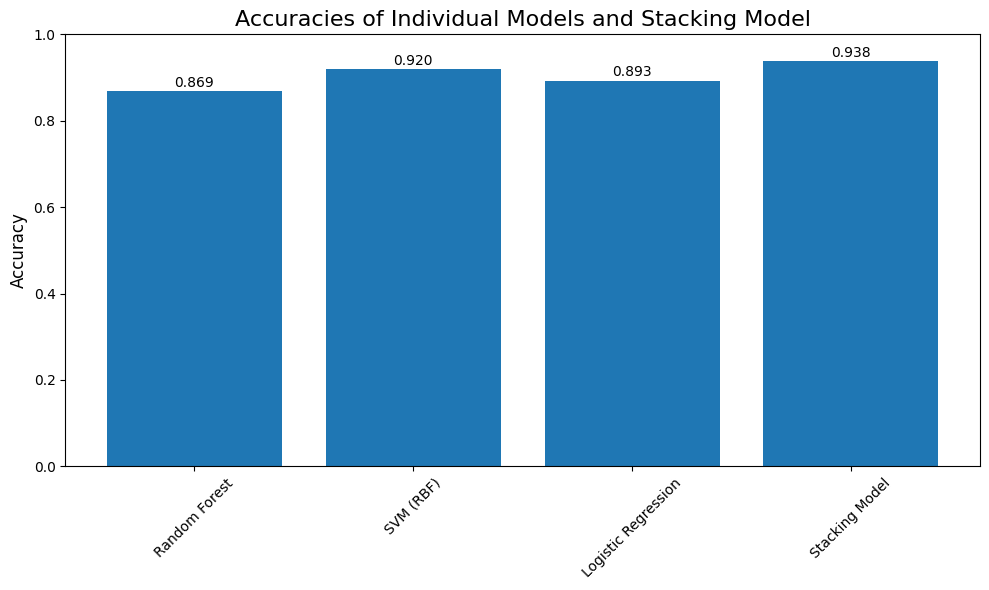

In [435]:
import matplotlib.pyplot as plt

# Fit each base estimator individually
base_estimators[0][1].fit(X_train, y_train)  # Random Forest
base_estimators[1][1].fit(X_train, y_train)  # SVM (RBF)
base_estimators[2][1].fit(X_train, y_train)  # Logistic Regression

# Accuracies of individual models in the stack
all_accuracies = {
    "Random Forest": accuracy_score(y_val, base_estimators[0][1].predict(X_val)),
    "SVM (RBF)": accuracy_score(y_val, base_estimators[1][1].predict(X_val)),
    "Logistic Regression": accuracy_score(y_val, base_estimators[2][1].predict(X_val)),
}

# Total accuracy of the stacking model
stacking_accuracy = accuracy_score(y_val, stacking_model.predict(X_val))

all_accuracies["Stacking Model"] = stacking_accuracy

# Plot the accuracies
plt.figure(figsize=(10, 6))
plt.bar(all_accuracies.keys(), all_accuracies.values())#, color=["skyblue", "lightgreen", "orange", "purple"])
plt.title("Accuracies of Individual Models and Stacking Model", fontsize=16)
plt.ylabel("Accuracy", fontsize=12)
plt.ylim(0, 1)
for i, v in enumerate(all_accuracies.values()):
    plt.text(i, v + 0.01, f"{v:.3f}", ha="center", fontsize=10)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

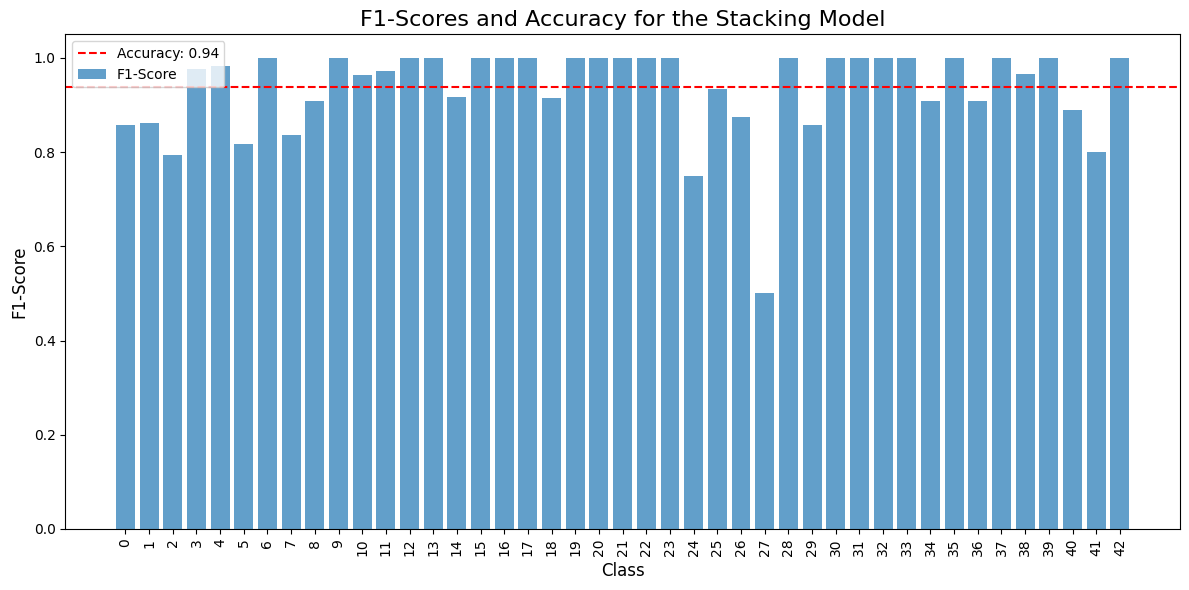

In [436]:
from sklearn.metrics import classification_report
import numpy as np
import matplotlib.pyplot as plt

# y_pred = .predict(X_val)

# Generate classification report
report = classification_report(y_val, val_preds, output_dict=True)

# Extract accuracy and F1-scores
accuracy = report["accuracy"]
f1_scores = [v["f1-score"] for k, v in report.items() if k.isdigit()]

# Plot F1-scores
plt.figure(figsize=(12, 6))
plt.bar(range(len(f1_scores)), f1_scores, alpha=0.7, label='F1-Score')
plt.axhline(y=accuracy, color='r', linestyle='--', label=f'Accuracy: {accuracy:.2f}')
plt.title("F1-Scores and Accuracy for the Stacking Model", fontsize=16)
plt.xlabel("Class", fontsize=12)
plt.ylabel("F1-Score", fontsize=12)
plt.xticks(range(len(f1_scores)), [k for k in report.keys() if k.isdigit()], rotation=90)
plt.legend()
plt.tight_layout()
plt.show()


## CNN

In [437]:
from sklearn.model_selection import train_test_split
import cv2
# Define image dimensions - smaller for faster training
IMG_HEIGHT, IMG_WIDTH = 96, 96

# Function to load and preprocess images
def load_images(image_paths, img_height=IMG_HEIGHT, img_width=IMG_WIDTH):
    images = []
    for path in image_paths:
        img = cv2.imread(path)
        if img is not None:
            img = cv2.resize(img, (img_width, img_height))
            img = img / 255.0  # Normalize
            images.append(img)
    return np.array(images)

# Get image paths and labels from train_df
image_paths = train_df['image_path'].values
labels = train_df['ClassId'].values

# Load images
X_images = load_images(image_paths)

# Split data
X_train_img, X_val_img, y_train_img, y_val_img = train_test_split(
    X_images, labels, test_size=0.2, random_state=42, stratify=labels
)

In [438]:
# Train a CNN to classify the images into classes
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
import numpy as np
import cv2
import os

# Define image dimensions - smaller for faster training
IMG_HEIGHT, IMG_WIDTH = 96, 96

# Function to load and preprocess images
def load_images(image_paths, img_height=IMG_HEIGHT, img_width=IMG_WIDTH):
    images = []
    for path in image_paths:
        img = cv2.imread(path)
        if img is not None:
            img = cv2.resize(img, (img_width, img_height))
            img = img / 255.0  # Normalize
            images.append(img)
    return np.array(images, dtype=np.float32)  # Explicitly set dtype to float32

# Get image paths and labels from train_df
image_paths = train_df['image_path'].values
labels = train_df['ClassId'].values.astype(np.int32)  # Convert labels to int32

# Load images
X_images = load_images(image_paths)

# Split data
X_train_img, X_val_img, y_train_img, y_val_img = train_test_split(
    X_images, labels, test_size=0.2, random_state=42, stratify=labels
)

# Data augmentation with fewer transformations for speed
datagen = ImageDataGenerator(
    rotation_range=0,
    width_shift_range=0.00001,
    height_shift_range=0.00001,
    zoom_range=0.001,
    horizontal_flip=False,
    fill_mode='nearest'
)

# Build a faster but still strong CNN model
def build_cnn_model(num_classes=43):
    return tf.keras.models.load_model('best_cnn_model_99_899.h5')
    model = models.Sequential([
        # First Convolutional Block
        layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
        layers.BatchNormalization(),
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Dropout(0.25),

        # Second Convolutional Block
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Dropout(0.25),

        # Third Convolutional Block
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Dropout(0.25),

        # Dense Layers
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    
    return model

cnn_model = build_cnn_model()
cnn_model.compile(
    optimizer=Adam(learning_rate=0.0005),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Add callbacks
reduce_lr = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.2,
    patience=2,
    min_lr=1e-6,
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

checkpoint = ModelCheckpoint(
    'best_cnn_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

# Train model with data augmentation
BATCH_SIZE = 32
# history = cnn_model.fit(
#     datagen.flow(X_train_img, y_train_img, batch_size=BATCH_SIZE),
#     steps_per_epoch=len(X_train_img) // BATCH_SIZE,
#     validation_data=(X_val_img, y_val_img),
#     epochs=40,
#     callbacks=[reduce_lr, early_stopping, checkpoint],
#     verbose=1
# )
cnn_model = tf.keras.models.load_model('best_cnn_model.h5')

# Evaluate model
val_loss, val_acc = cnn_model.evaluate(X_val_img, y_val_img)
print(f"Validation accuracy: {val_acc:.4f}")

# Make predictions on test set
# test_image_paths = test_df['image_path'].values
# X_test_img = load_images(test_image_paths)
# cnn_predictions = cnn_model.predict(X_test_img)
# cnn_pred_classes = np.argmax(cnn_predictions, axis=1)

# # Save CNN predictions
# cnn_pred_df = pd.DataFrame({'id': test_df['id'], 'ClassId': cnn_pred_classes})
# cnn_pred_df.set_index('id', inplace=True)
# cnn_pred_df.to_csv('cnn_predictions.csv')

35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9843 - loss: 0.0719
Validation accuracy: 0.9872


18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step


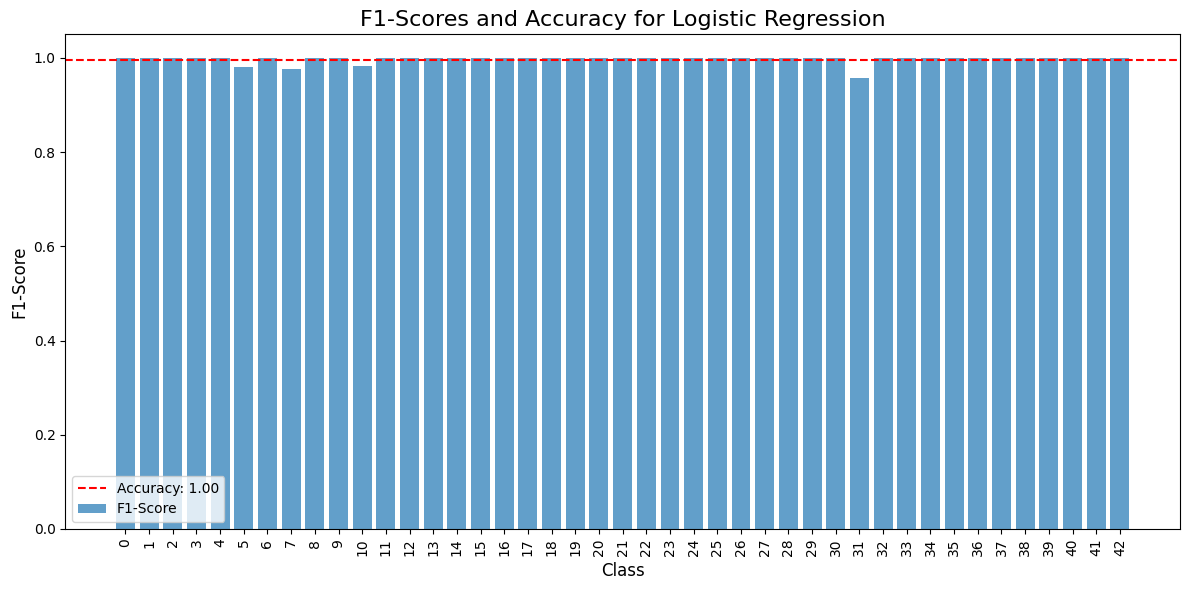

In [ ]:
# plot for CNN
from sklearn.metrics import classification_report
import numpy as np
import matplotlib.pyplot as plt

y_pred = np.argmax(cnn_model.predict(load_images(train_df_val["image_path"].values)), axis =1)

report = classification_report(y_val, y_pred, output_dict=True)

accuracy = report["accuracy"]
f1_scores = [v["f1-score"] for k, v in report.items() if k.isdigit()]

plt.figure(figsize=(12, 6))
plt.bar(range(len(f1_scores)), f1_scores, alpha=0.7, label='F1-Score')
plt.axhline(y=accuracy, color='r', linestyle='--', label=f'Accuracy: {accuracy:.2f}')
plt.title("F1-Scores and Accuracy for Logistic Regression", fontsize=16)
plt.xlabel("Class", fontsize=12)
plt.ylabel("F1-Score", fontsize=12)
plt.xticks(range(len(f1_scores)), [k for k in report.keys() if k.isdigit()], rotation=90)
plt.legend()
plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


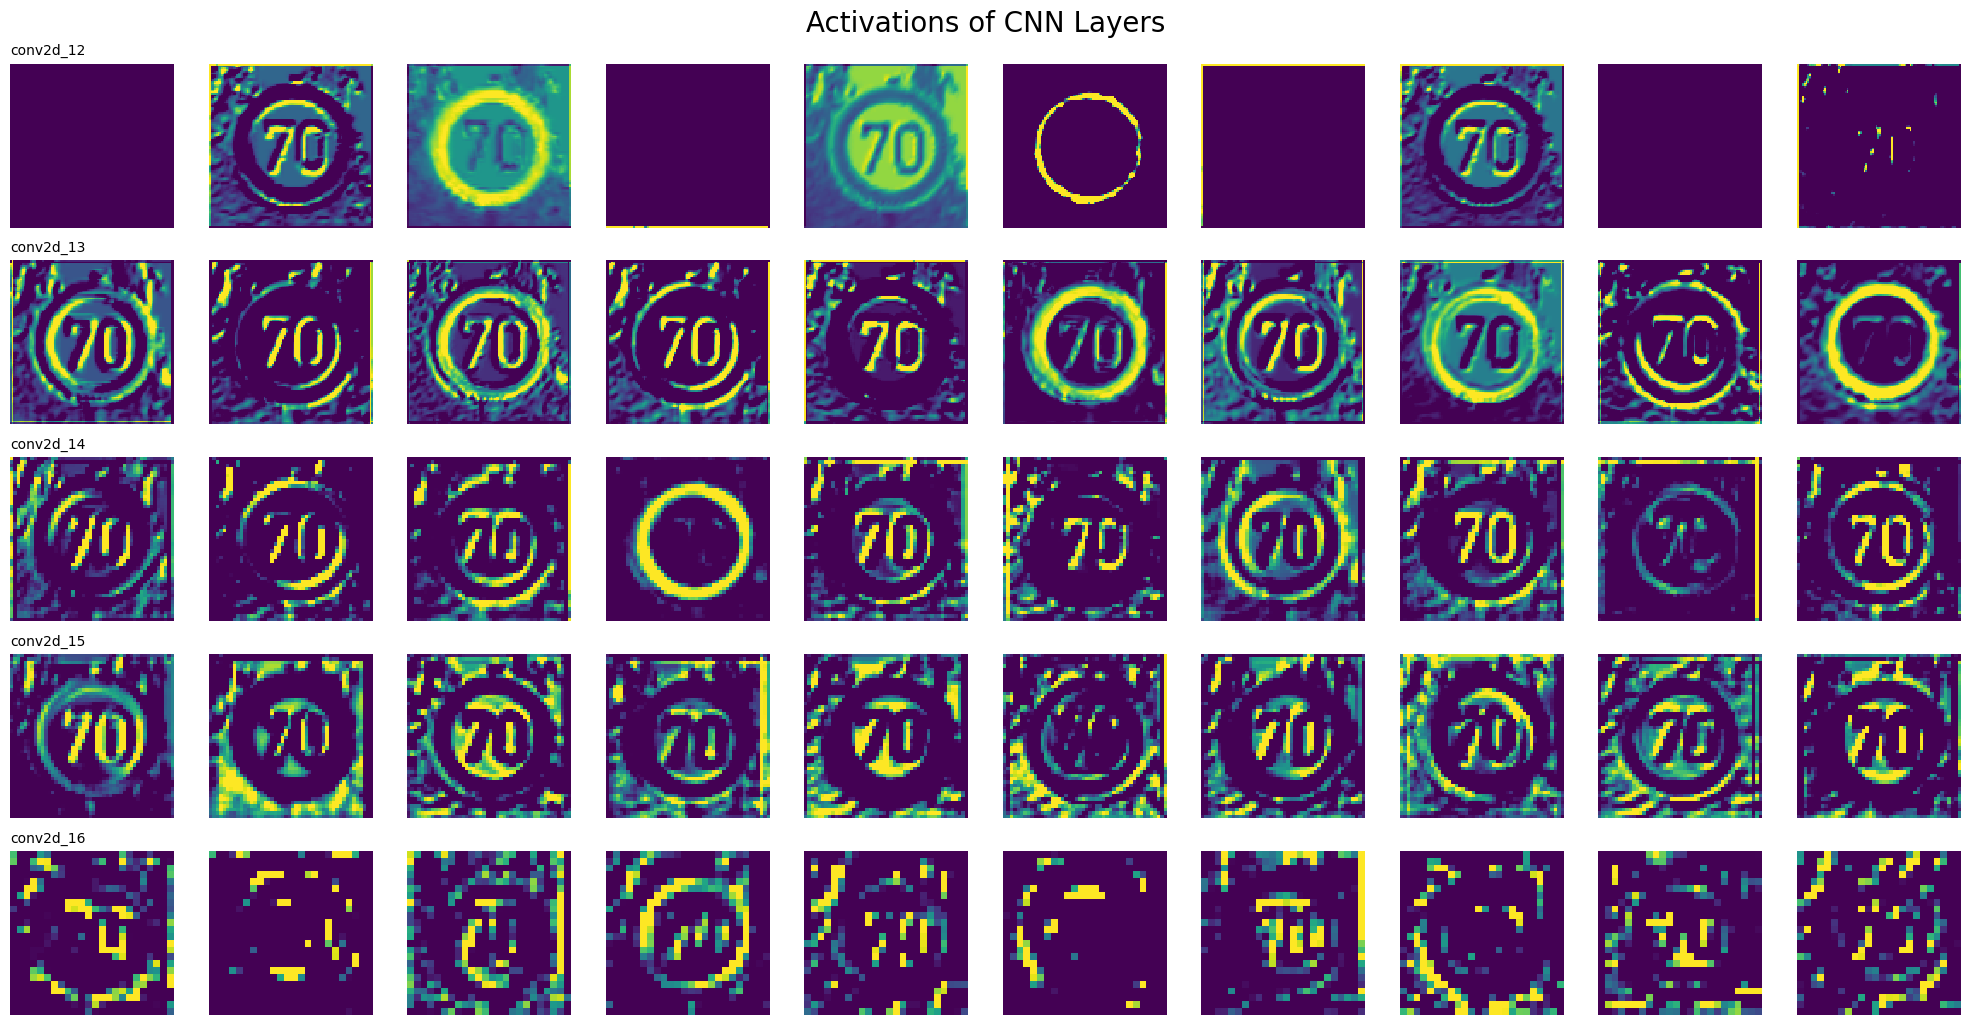

In [443]:
# plot the activaitions of the CNN
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import cv2

cnn_model = tf.keras.models.load_model('best_cnn_model_98_91.keras')
_, H, W, C = cnn_model.input_shape
inp = tf.keras.Input(shape=(H, W, C))
x = inp
layer_outputs, layer_names = [], []
for layer in cnn_model.layers:
    x = layer(x)
    if isinstance(layer, tf.keras.layers.Conv2D) or 'activation' in layer.name:
        layer_outputs.append(x)
        layer_names.append(layer.name)
activation_model = tf.keras.Model(inputs=inp, outputs=layer_outputs)

def load_and_prep(path):
    img = cv2.imread(path)
    img = cv2.resize(img, (W, H))
    img = img.astype('float32') / 255.0
    return np.expand_dims(img, 0)

image_path = test_df['image_path'].iloc[7] # just an example image that works well
img = load_and_prep(image_path)

# get activations
activations = activation_model.predict(img)

n_layers = min(5, len(activations)) 
n_filters = 10                      

fig, axes = plt.subplots(n_layers, n_filters,
                         figsize=(n_filters * 2, n_layers * 2),
                         squeeze=False)

for row in range(n_layers):
    act = activations[row][0]
    h, w, c = act.shape
    for col in range(n_filters):
        fmap = act[:, :, col]
        f = fmap - fmap.mean()
        f = f / (fmap.std() + 1e-5)
        f = np.clip((f * 64 + 128), 0, 255).astype('uint8')
        
        ax = axes[row, col]
        ax.imshow(f, cmap='viridis', interpolation='nearest', aspect='equal')
        ax.axis('off')
        
        if col == 0:
            ax.set_title(layer_names[row], fontsize=10, loc='left')
            ax.set_ylabel(layer_names[row], fontsize=8)

plt.tight_layout()
plt.suptitle('Activations of CNN Layers', fontsize=20, y=1.02)
plt.show()

In [442]:
# cnn_pred_df.to_csv('cnn_predictions.csv')

# Visualizations

In [ ]:
accuracy_score(lr_model.predict(X_val), y_val)

0.8870673952641166

In [ ]:
X_val_img = load_images(train_df.loc[val_idx]['image_path'].values)
X_train_img = load_images(train_df.loc[train_idx]['image_path'].values)
y_train_img = train_df.loc[train_idx]['ClassId'].values
y_val_img = train_df.loc[val_idx]['ClassId'].values

# cnn_model = tf.keras.models.load_model('best_cnn_model_99_899.h5')

y_pred = cnn_model.predict(X_val_img)
y_pred_classes = np.argmax(y_pred, axis=1)

# accuracy_score(y_val_img, y_pred_classes)

all_models = {
    "SVM": svm_model,
    "KNN": knn_model,
    "Logistic Regression": lr_model,
    # "Stacking": stacking_model,
    # "CNN": cnn_model
}

all_models = {'rf': RandomForestClassifier(
        n_estimators=300, max_depth=20, n_jobs=-1, random_state=42, class_weight='balanced_subsample'),
    'svm_rbf':  SVC(
        kernel='rbf', C=10, gamma='scale', probability=True, random_state=42
    ),
    # Logistic Regression: simple, interpretable linear model
    'lr': LogisticRegression(
        max_iter=500, solver='lbfgs', C=3, random_state=42
    )}
all_models = {"rf": rf, 
              "svm": svm, 
              "lr": lr, 
              "stacking": stacking_model}

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


/Users/duncanjcartwright/Documents/uni_stuff/year3/ML/assignments/ass2/tf-metal/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/duncanjcartwright/Documents/uni_stuff/year3/ML/assignments/ass2/tf-metal/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/duncanjcartwright/Documents/uni_stuff/year3/ML/assignments/ass2/tf-metal/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in label

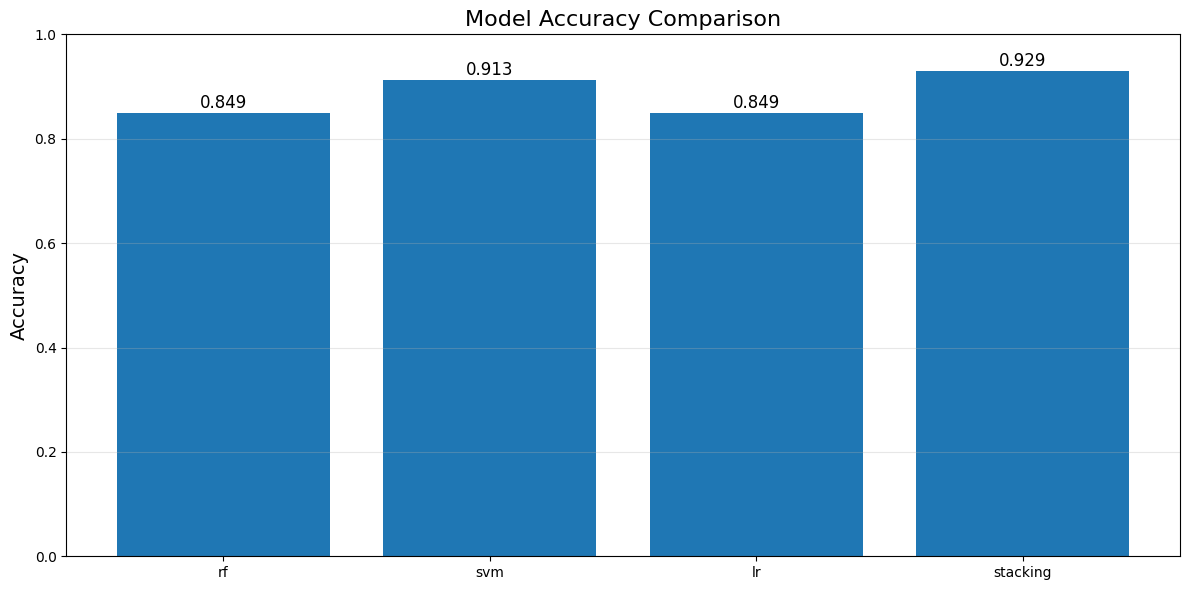

/var/folders/f8/7bfj312x46n0l2_hr_xk_tdr0000gn/T/ipykernel_28892/3415049754.py:70: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(boxplot_data, labels=boxplot_labels, patch_artist=True)


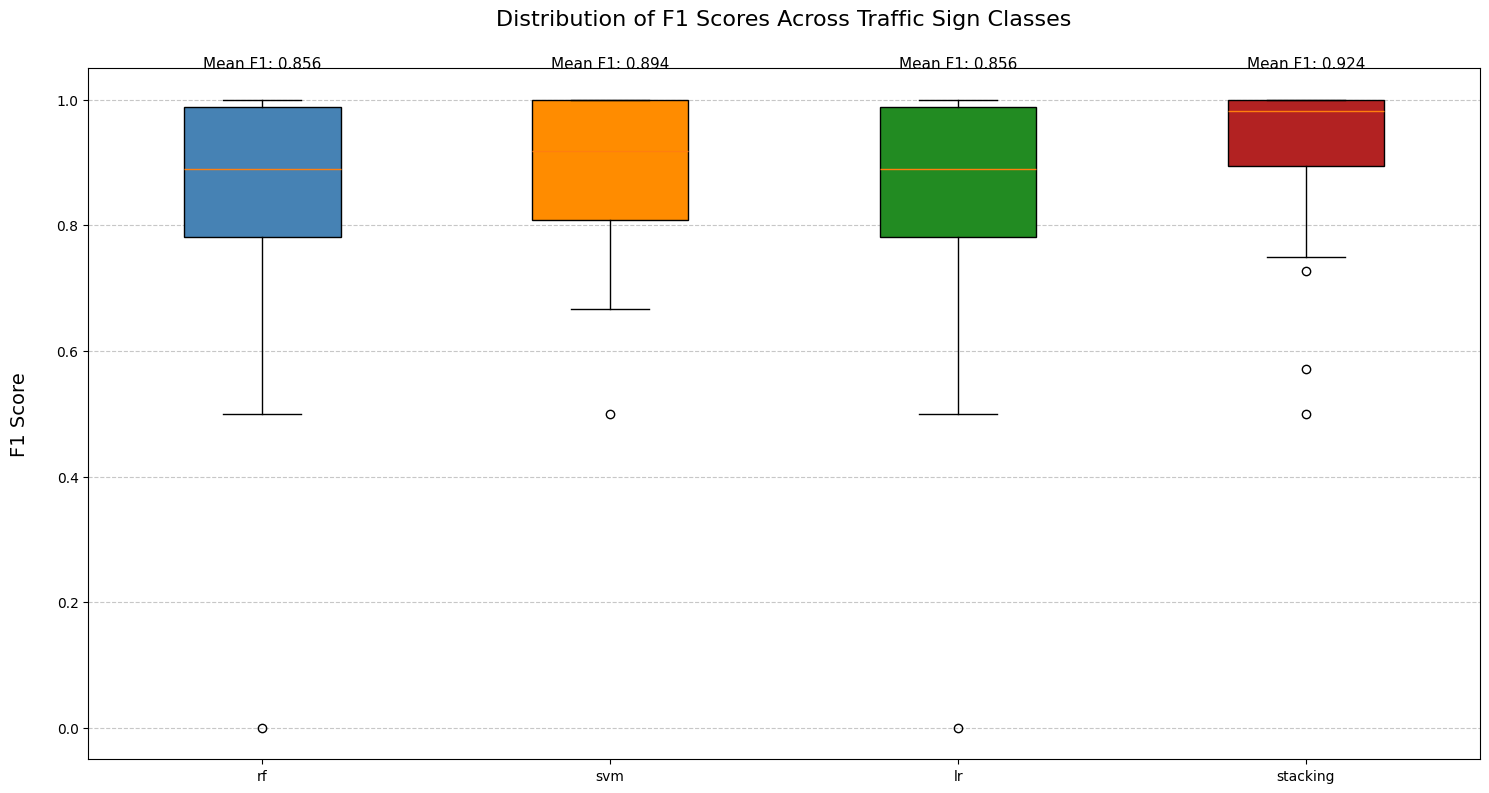

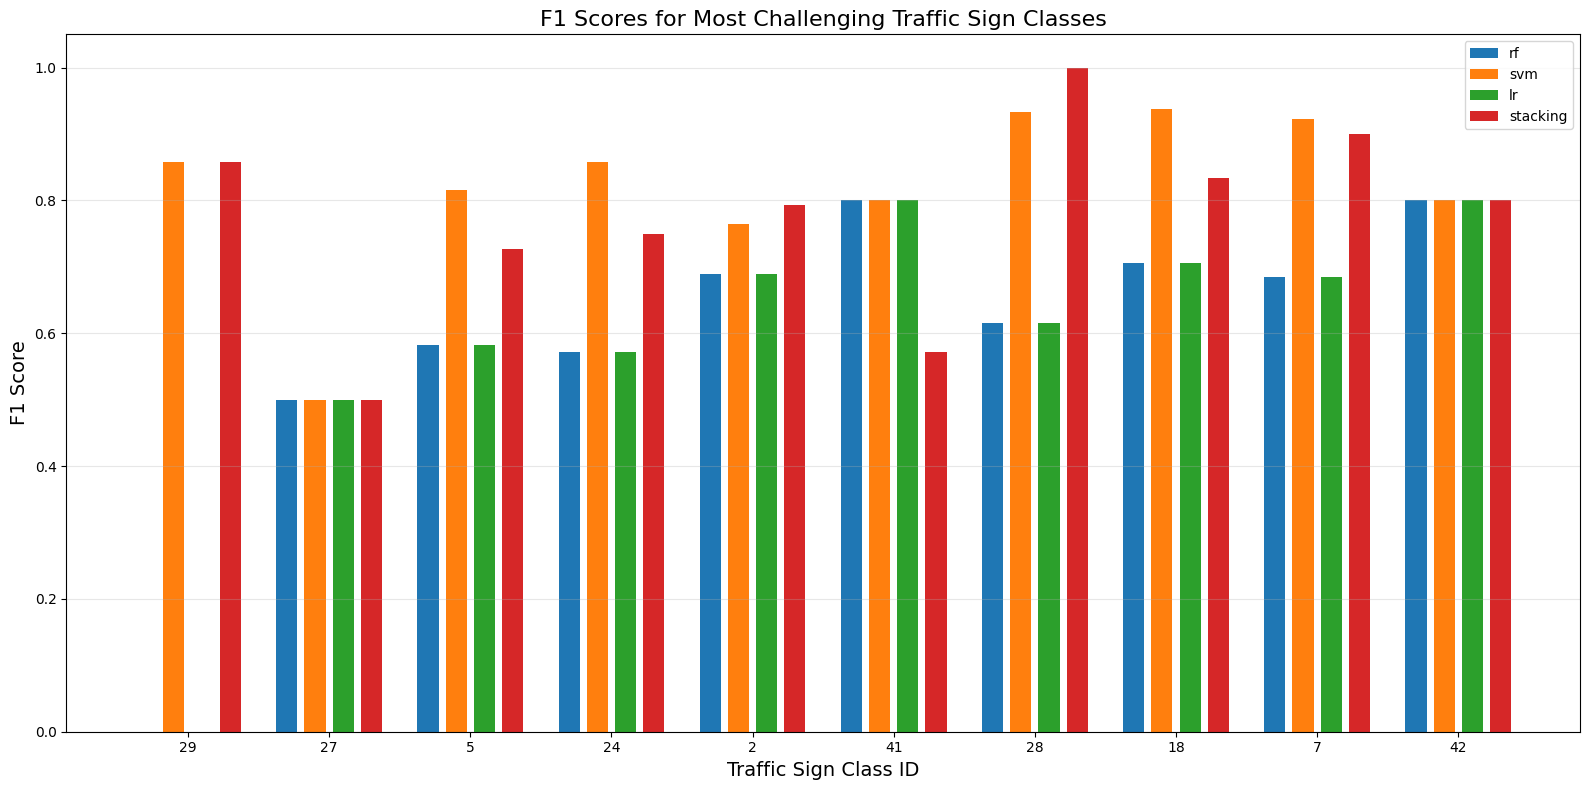

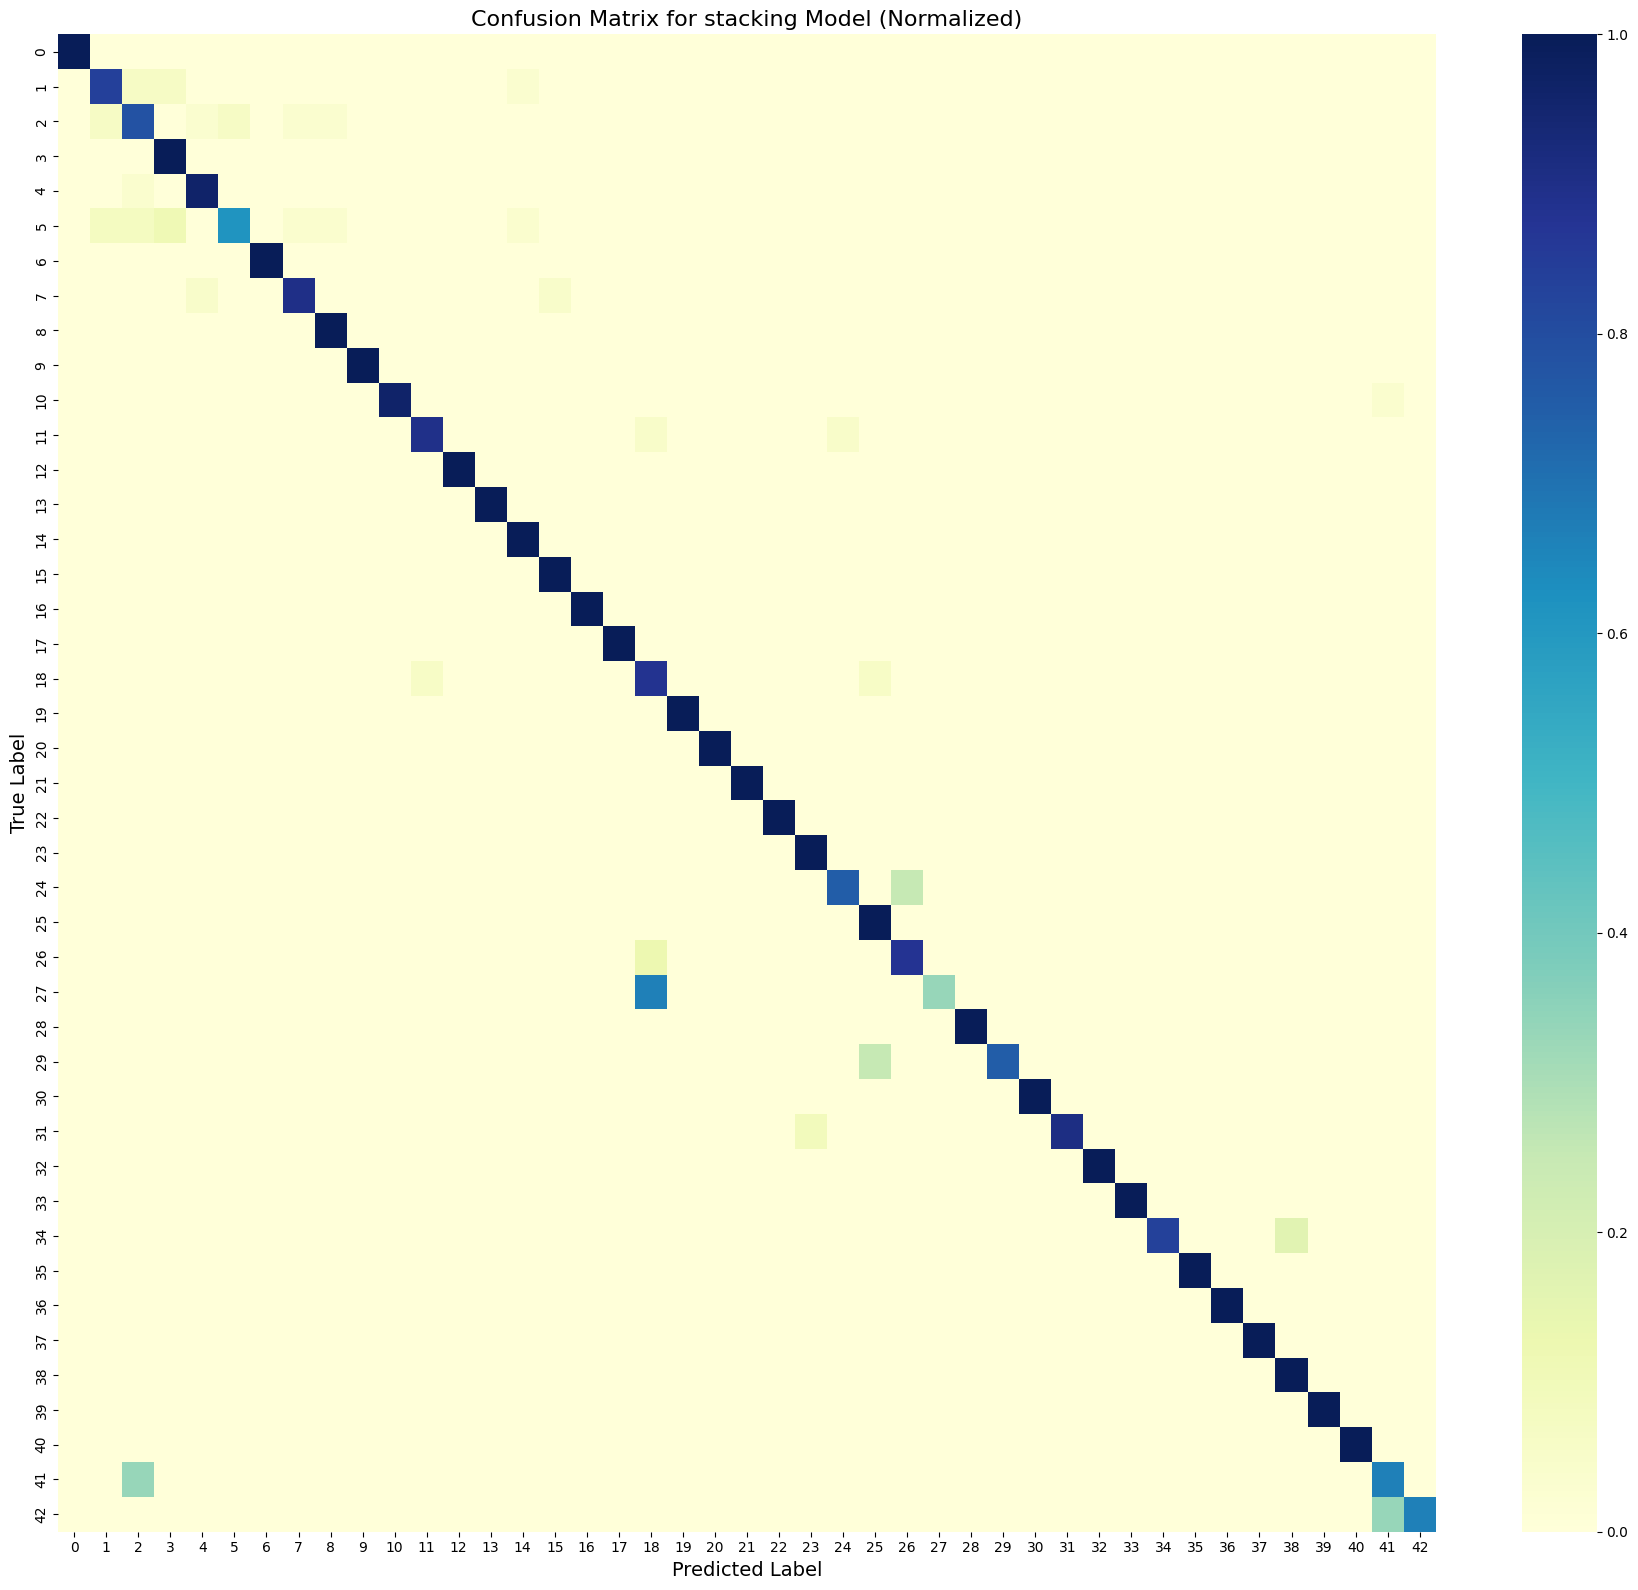

In [447]:
# some general plots
import tensorflow as tf
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def get_model_predictions(model, X_val_data):
    # for tf
    if isinstance(model, tf.keras.Model):
        preds = model.predict(X_val_img)
        return np.argmax(preds, axis=1)
    else:  
        # for other
        return model.predict(X_val)

model_accuracies = {}
model_f1_scores = {}
model_predictions = {}
confusion_matrices = {}

for name, model in all_models.items():
    if name == "CNN":
        preds = get_model_predictions(model, X_val_img)
        y_true = y_val_img
    else:
        preds = get_model_predictions(model, X_val)
        y_true = y_val
    
    model_predictions[name] = preds
    
    accuracy = accuracy_score(y_true, preds)
    report = classification_report(y_true, preds, output_dict=True)
    
    cm = confusion_matrix(y_true, preds)
    confusion_matrices[name] = cm
    
    model_accuracies[name] = accuracy
    
    f1_scores = []
    for i in range(43): 
        if str(i) in report:
            f1_scores.append(report[str(i)]["f1-score"])
        else:
            f1_scores.append(0) 
    
    model_f1_scores[name] = f1_scores

plt.figure(figsize=(12, 6))
bars = plt.bar(model_accuracies.keys(), model_accuracies.values() )
plt.title("Model Accuracy Comparison", fontsize=16)
plt.ylabel("Accuracy", fontsize=14)
plt.ylim(0, 1)
plt.grid(axis='y', alpha=0.3)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
            f'{height:.3f}', ha='center', fontsize=12)

plt.tight_layout()
plt.show()

# F1 Score Distribution Across Classes plot
plt.figure(figsize=(15, 8))

boxplot_data = [scores for scores in model_f1_scores.values()]
boxplot_labels = list(model_f1_scores.keys())

box = plt.boxplot(boxplot_data, labels=boxplot_labels, patch_artist=True)
colors = ['steelblue', 'darkorange', 'forestgreen', 'firebrick', 'mediumpurple']

for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)

plt.title("Distribution of F1 Scores Across Traffic Sign Classes", fontsize=16, y =1.05)
plt.ylabel("F1 Score\n", fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)

for i, scores in enumerate(boxplot_data):
    mean_f1 = np.mean([s for s in scores if s > 0])
    plt.text(i+1, 1.05, f"Mean F1: {mean_f1:.3f}", ha="center", fontsize=11)

plt.tight_layout()
plt.show()
avg_f1_per_class = np.zeros(43)
for f1_scores in model_f1_scores.values():
    avg_f1_per_class += np.array(f1_scores)
avg_f1_per_class /= len(model_f1_scores)
worst_classes = np.argsort(avg_f1_per_class)[:10]

plt.figure(figsize=(16, 8))
x = np.arange(len(worst_classes))
width = 0.15
offsets = np.linspace(-0.3, 0.3, len(model_f1_scores))

for i, (model_name, f1_scores) in enumerate(model_f1_scores.items()):
    worst_f1 = [f1_scores[cls] for cls in worst_classes]
    plt.bar(x + offsets[i], worst_f1, width, label=model_name)

plt.xlabel('Traffic Sign Class ID', fontsize=14)
plt.ylabel('F1 Score', fontsize=14)
plt.title('F1 Scores for Most Challenging Traffic Sign Classes', fontsize=16)
plt.xticks(x, worst_classes)
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

best_model = max(model_accuracies, key=model_accuracies.get)
plt.figure(figsize=(18, 16))
cm = confusion_matrices[best_model]

cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm_normalized = np.nan_to_num(cm_normalized)  # Replace NaNs with 0

sns.heatmap(cm_normalized, annot=False, cmap="YlGnBu", 
            xticklabels=range(43), yticklabels=range(43))
plt.title(f'Confusion Matrix for {best_model} Model (Normalized)', fontsize=16)
plt.xlabel('Predicted Label', fontsize=14)
plt.ylabel('True Label', fontsize=14)
plt.tight_layout()
plt.show()

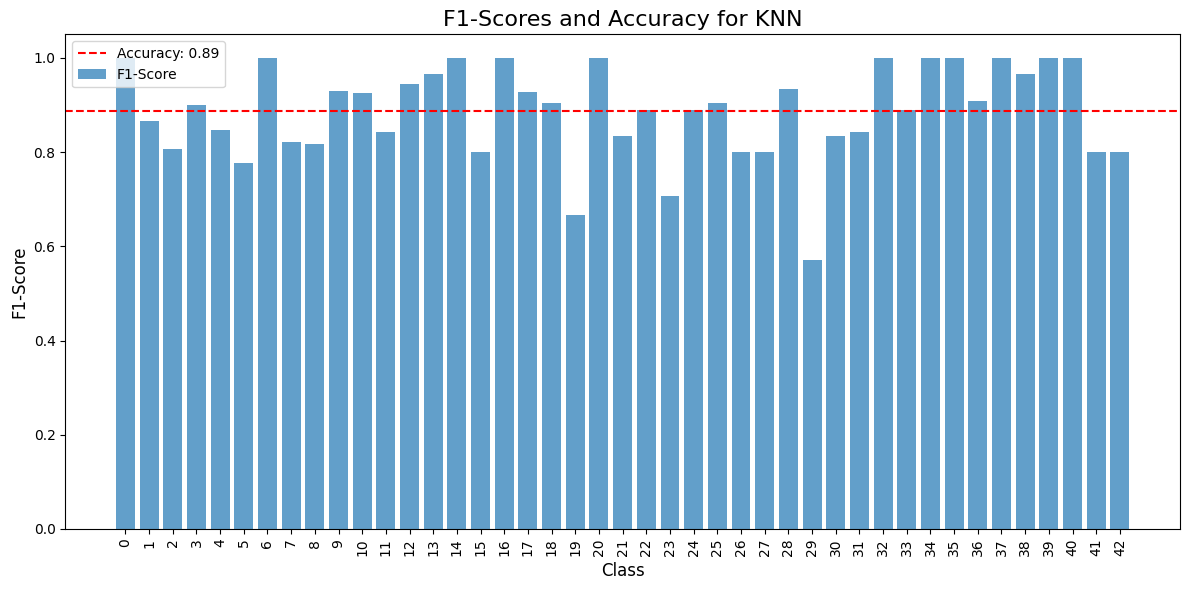

In [449]:
# knn performance summary
from sklearn.metrics import classification_report
import numpy as np
import matplotlib.pyplot as plt

y_pred = knn_model.predict(X_val)

report = classification_report(y_val, y_pred, output_dict=True)

accuracy = report["accuracy"]
f1_scores = [v["f1-score"] for k, v in report.items() if k.isdigit()]

plt.figure(figsize=(12, 6))
plt.bar(range(len(f1_scores)), f1_scores, alpha=0.7, label='F1-Score')
plt.axhline(y=accuracy, color='r', linestyle='--', label=f'Accuracy: {accuracy:.2f}')
plt.title("F1-Scores and Accuracy for KNN", fontsize=16)
plt.xlabel("Class", fontsize=12)
plt.ylabel("F1-Score", fontsize=12)
plt.xticks(range(len(f1_scores)), [k for k in report.keys() if k.isdigit()], rotation=90)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# compare all models
from sklearn.metrics import accuracy_score, f1_score

in_sample_accuracies = {}
out_of_sample_accuracies = {}
in_sample_f1_macro = {}
out_of_sample_f1_macro = {}
in_sample_f1_weighted = {}
out_of_sample_f1_weighted = {}

for name, model in all_models.items():
    if name == "CNN":
        # For CNN, use the image data
        y_train_pred = np.argmax(model.predict(X_train_img), axis=1)
        y_val_pred = np.argmax(model.predict(X_val_img), axis=1)
    else:
        # for other models, use the tabular data
        y_train_pred = model.predict(X_train)
        y_val_pred = model.predict(X_val)
    
    in_sample_accuracies[name] = accuracy_score(y_train, y_train_pred)
    out_of_sample_accuracies[name] = accuracy_score(y_val, y_val_pred)
    
    in_sample_f1_macro[name] = f1_score(y_train, y_train_pred, average='macro')
    out_of_sample_f1_macro[name] = f1_score(y_val, y_val_pred, average='macro')
    in_sample_f1_weighted[name] = f1_score(y_train, y_train_pred, average='weighted')
    out_of_sample_f1_weighted[name] = f1_score(y_val, y_val_pred, average='weighted')

print("In-sample accuracies:")
for name, acc in in_sample_accuracies.items():
    print(f"{name}: {acc:.4f}")

print("\nOut-of-sample accuracies:")
for name, acc in out_of_sample_accuracies.items():
    print(f"{name}: {acc:.4f}")

print("\nIn-sample F1 (Macro):")
for name, f1 in in_sample_f1_macro.items():
    print(f"{name}: {f1:.4f}")

print("\nOut-of-sample F1 (Macro):")
for name, f1 in out_of_sample_f1_macro.items():
    print(f"{name}: {f1:.4f}")

print("\nIn-sample F1 (Weighted):")
for name, f1 in in_sample_f1_weighted.items():
    print(f"{name}: {f1:.4f}")

print("\nOut-of-sample F1 (Weighted):")
for name, f1 in out_of_sample_f1_weighted.items():
    print(f"{name}: {f1:.4f}")


In-sample accuracies:
rf: 0.9763
svm: 0.9998
lr: 0.9763
stacking: 0.9951

Out-of-sample accuracies:
rf: 0.8488
svm: 0.9126
lr: 0.8488
stacking: 0.9290

In-sample F1 (Macro):
rf: 0.9831
svm: 0.9999
lr: 0.9831
stacking: 0.9966

Out-of-sample F1 (Macro):
rf: 0.8363
svm: 0.8944
lr: 0.8363
stacking: 0.9243

In-sample F1 (Weighted):
rf: 0.9763
svm: 0.9998
lr: 0.9763
stacking: 0.9952

Out-of-sample F1 (Weighted):
rf: 0.8456
svm: 0.9115
lr: 0.8456
stacking: 0.9269


# Feature engineering

In [451]:
from sklearn.feature_selection import mutual_info_classif

mi_scores = mutual_info_classif(X_train, y_train)

In [452]:
MI_cols = X_train.columns[mi_scores > 0.05]
MI_cols = MI_cols.tolist()
len(MI_cols) , len(X_train.columns)

(163, 204)

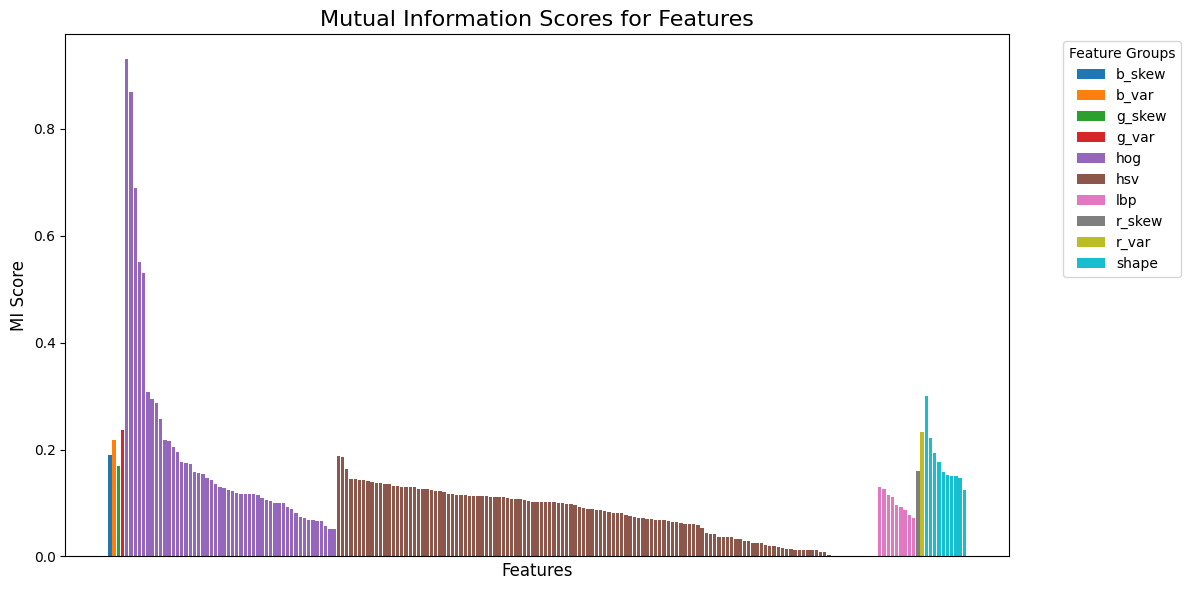

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

mi_scores_df = pd.DataFrame({
    'Feature': X_train.columns,
    'MI Score': mi_scores
})

mi_scores_df['Prefix'] = mi_scores_df['Feature'].str.extract(r'^([^_]+)_') 

# Correctly assign prefixes for features starting with 'r', 'g', or 'b'
for i in range(len(mi_scores_df)):
    feat = mi_scores_df['Feature'][i]
    pre = feat.split('_')[0]
    if pre in ['r', 'g', 'b']:
        mi_scores_df.at[i, 'Prefix'] = feat

mi_scores_df = mi_scores_df.sort_values(by=['Prefix', 'MI Score'], ascending=[True, False])

# Plot the MI scores grouped by prefix
plt.figure(figsize=(12, 6))
for prefix, group in mi_scores_df.groupby('Prefix'):
    plt.bar(group['Feature'], group['MI Score'], label=prefix)

plt.title('Mutual Information Scores for Features', fontsize=16)
plt.xlabel('Features', fontsize=12)
plt.ylabel('MI Score', fontsize=12)
plt.legend(title='Feature Groups', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks([], []) 
plt.tight_layout()
plt.show()


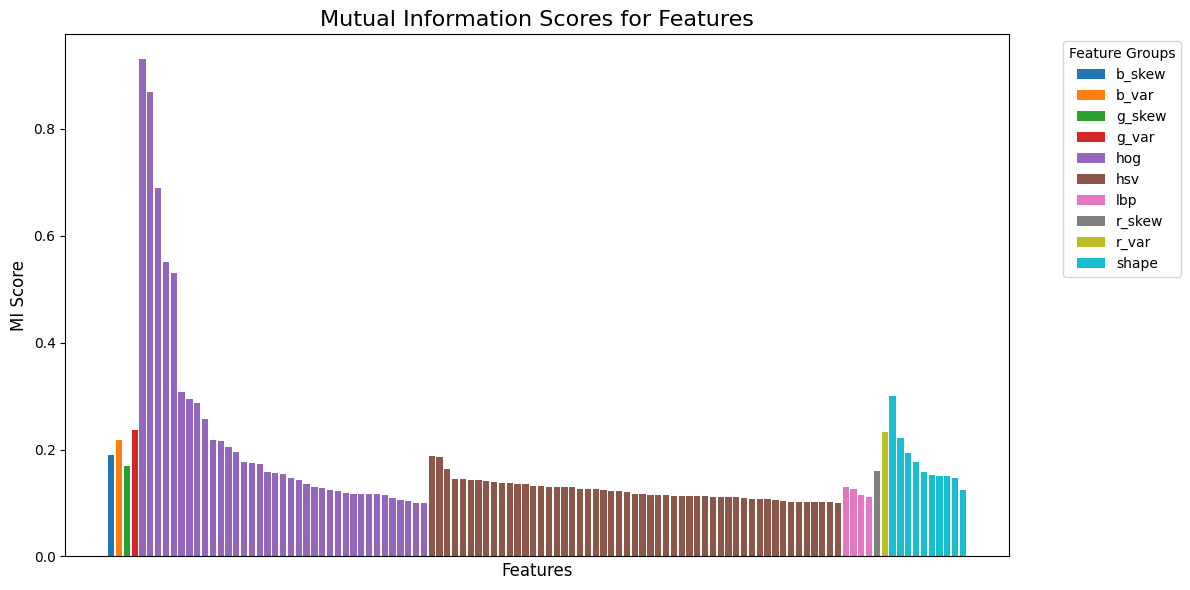

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Get indices of features with MI scores > 0.1
high_mi_indices = np.where(mi_scores > 0.1)[0]

mi_scores_df = pd.DataFrame({
    'Feature': X_train.columns[high_mi_indices],
    'MI Score': mi_scores[high_mi_indices]
})

mi_scores_df['Prefix'] = mi_scores_df['Feature'].str.extract(r'^([^_]+)_') 

for i in range(len(mi_scores_df)):
    feat = mi_scores_df['Feature'][i]
    pre = feat.split('_')[0]
    if pre in ['r', 'g', 'b']:
        mi_scores_df.at[i, 'Prefix'] = feat

mi_scores_df = mi_scores_df.sort_values(by=['Prefix', 'MI Score'], ascending=[True, False])

# Plot the MI scores grouped by prefix
plt.figure(figsize=(12, 6))
for prefix, group in mi_scores_df.groupby('Prefix'):
    plt.bar(group['Feature'], group['MI Score'], label=prefix)

plt.title('Mutual Information Scores for Features', fontsize=16)
plt.xlabel('Features', fontsize=12)
plt.ylabel('MI Score', fontsize=12)
plt.legend(title='Feature Groups', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks([], []) 
plt.tight_layout()
plt.show()

In [ ]:
# Select features with mutual information score above a threshold (e.g., 0.2)
FEATURE_SELECTED = X_train.columns[mi_scores > 0.2].tolist()

print(f"Selected {len(FEATURE_SELECTED)} features:")
print(FEATURE_SELECTED)

Selected 17 features:
['shape_feat_0', 'shape_feat_3', 'r_var', 'g_var', 'b_var', 'hog_pca_0', 'hog_pca_1', 'hog_pca_2', 'hog_pca_3', 'hog_pca_4', 'hog_pca_6', 'hog_pca_7', 'hog_pca_8', 'hog_pca_9', 'hog_pca_12', 'hog_pca_14', 'hog_pca_15']
